In [120]:
import requests
from IPython.core.display import HTML

# Assignment introduction

**Overview**
This is the first mandatory assignment in which you will implement a regression model to estimate where a person is looking (this is known as _gaze_) from images of eyes.
You have to hand in this Jupyter Notebook with your implementation and notes, see the bottom of this page for handin details. For the TA's to assess the assignment we kindly ask you to also hand in the `data`
 folder. If you are not comfortable sharing your data with the TA's leave that folder out for the handin, but provide the plots for assessment. Refer to the bottom of the page for submission details.
Before you start solving the assignment, carefully read through the entire assignment to get an overview of the problem and the tasks.
Notice that the optional Task 23 and onward relates to exercises in next week. You may save some time by postponing it until then.
**Note:** **Important!** Complete all tasks marked with **high (red)** priority before attempting to solve the others, as they are optional. Optional tasks and further analysis can help improve results, but feel free to explore methods and data as you choose.


The assignment builds on the Data preprocessing
 exercise using the data in the `data`
 folder as well as your own. You will start with the data of `test_subject_0`
. You will then try out the model using the data from the data collection session.
The assignment is structured in the following way:
- Train gaze estimation models using data from `test_subject_0`
 training set.    - Test the models using `test_subject_0`
 test set.
    - Test the models using `test_subject_3`
.


- Train gaze estimation models using data from `test_subject_3`
, `grid`
.    - Test the models using `test_subject_3`
. 


- Train gaze estimtion models using your own data set. 


**Note**
The assignment has multiple steps, but the procedures will repeat. Duplicate code as needed to keep results in each cell, making it easier to review during the exam.
To simplify the assignment, most visualization and data processing code is in `iml_util.py`
. You can review it, but you're not expected to explain it. Focus on the code provided in the assignment.

<div style="float: none; width: 100%; justify-content: start" class="block is-clearfix">

**Note:** The location of the _fovea_ on the retina varies between people ($\pm$ 5 degrees). Consequently, a gaze model has to be trained (calibrated) for a specific person to be accurate. This difference is shown in [Figure 1](#kappa).

## Gaze Estimation introduction
Gaze estimation is performed by capturing images of a user's eye as shown in [Figure 2](#model) and mapping them to screen positions using a function $f_\mathbf{w}(x, y)$. Humans look at things by orienting their eyes so that the light from the point of focus hits the _Fovea_ (a point on the retina). The Fovea is not directly aligned with the center of the pupil, but at a person-specific angle, as shown in [Figure 1](#kappa). The pupil position can be used to infer gaze, but to obtain accurate gaze estimates requires training data (called calibration).


</div>

<div style="float: none; width: 100%; justify-content: start" class="block is-clearfix">



</div>


<div style="float: none; width: 100%; justify-content: start" class="block is-clearfix">

<div style="float: left; width: 50%; justify-content: start" class="block is-clearfix">

<div class="has-text-centered">
<figure class="image is-inline-block" id="kappa">

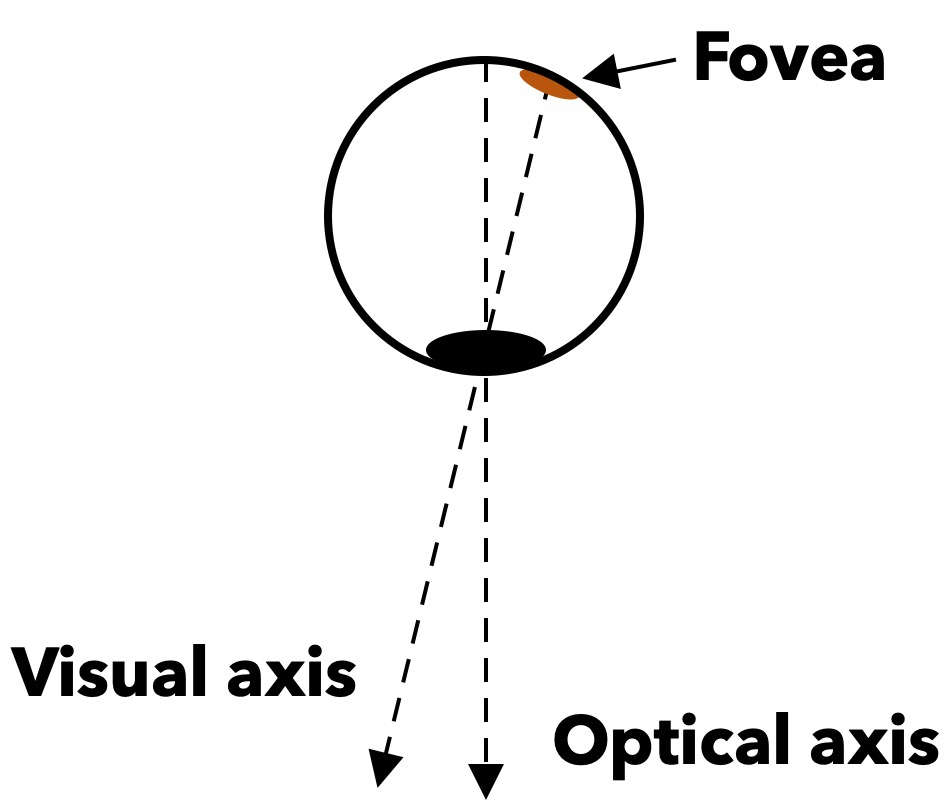

<figcaption class="figure-caption has-text-left">Figure 1: The distinction between the visual and optical axes. The optical axis is defined as an axis perpendicular to the lens behind the pupil. The visual axis depends on the placement of the _fovea_.
</figcaption>
</figure>
</div>


</div>

<div style="float: right; width: 50%; justify-content: start" class="block is-clearfix">

<div class="has-text-centered">
<figure class="image is-inline-block" id="model">

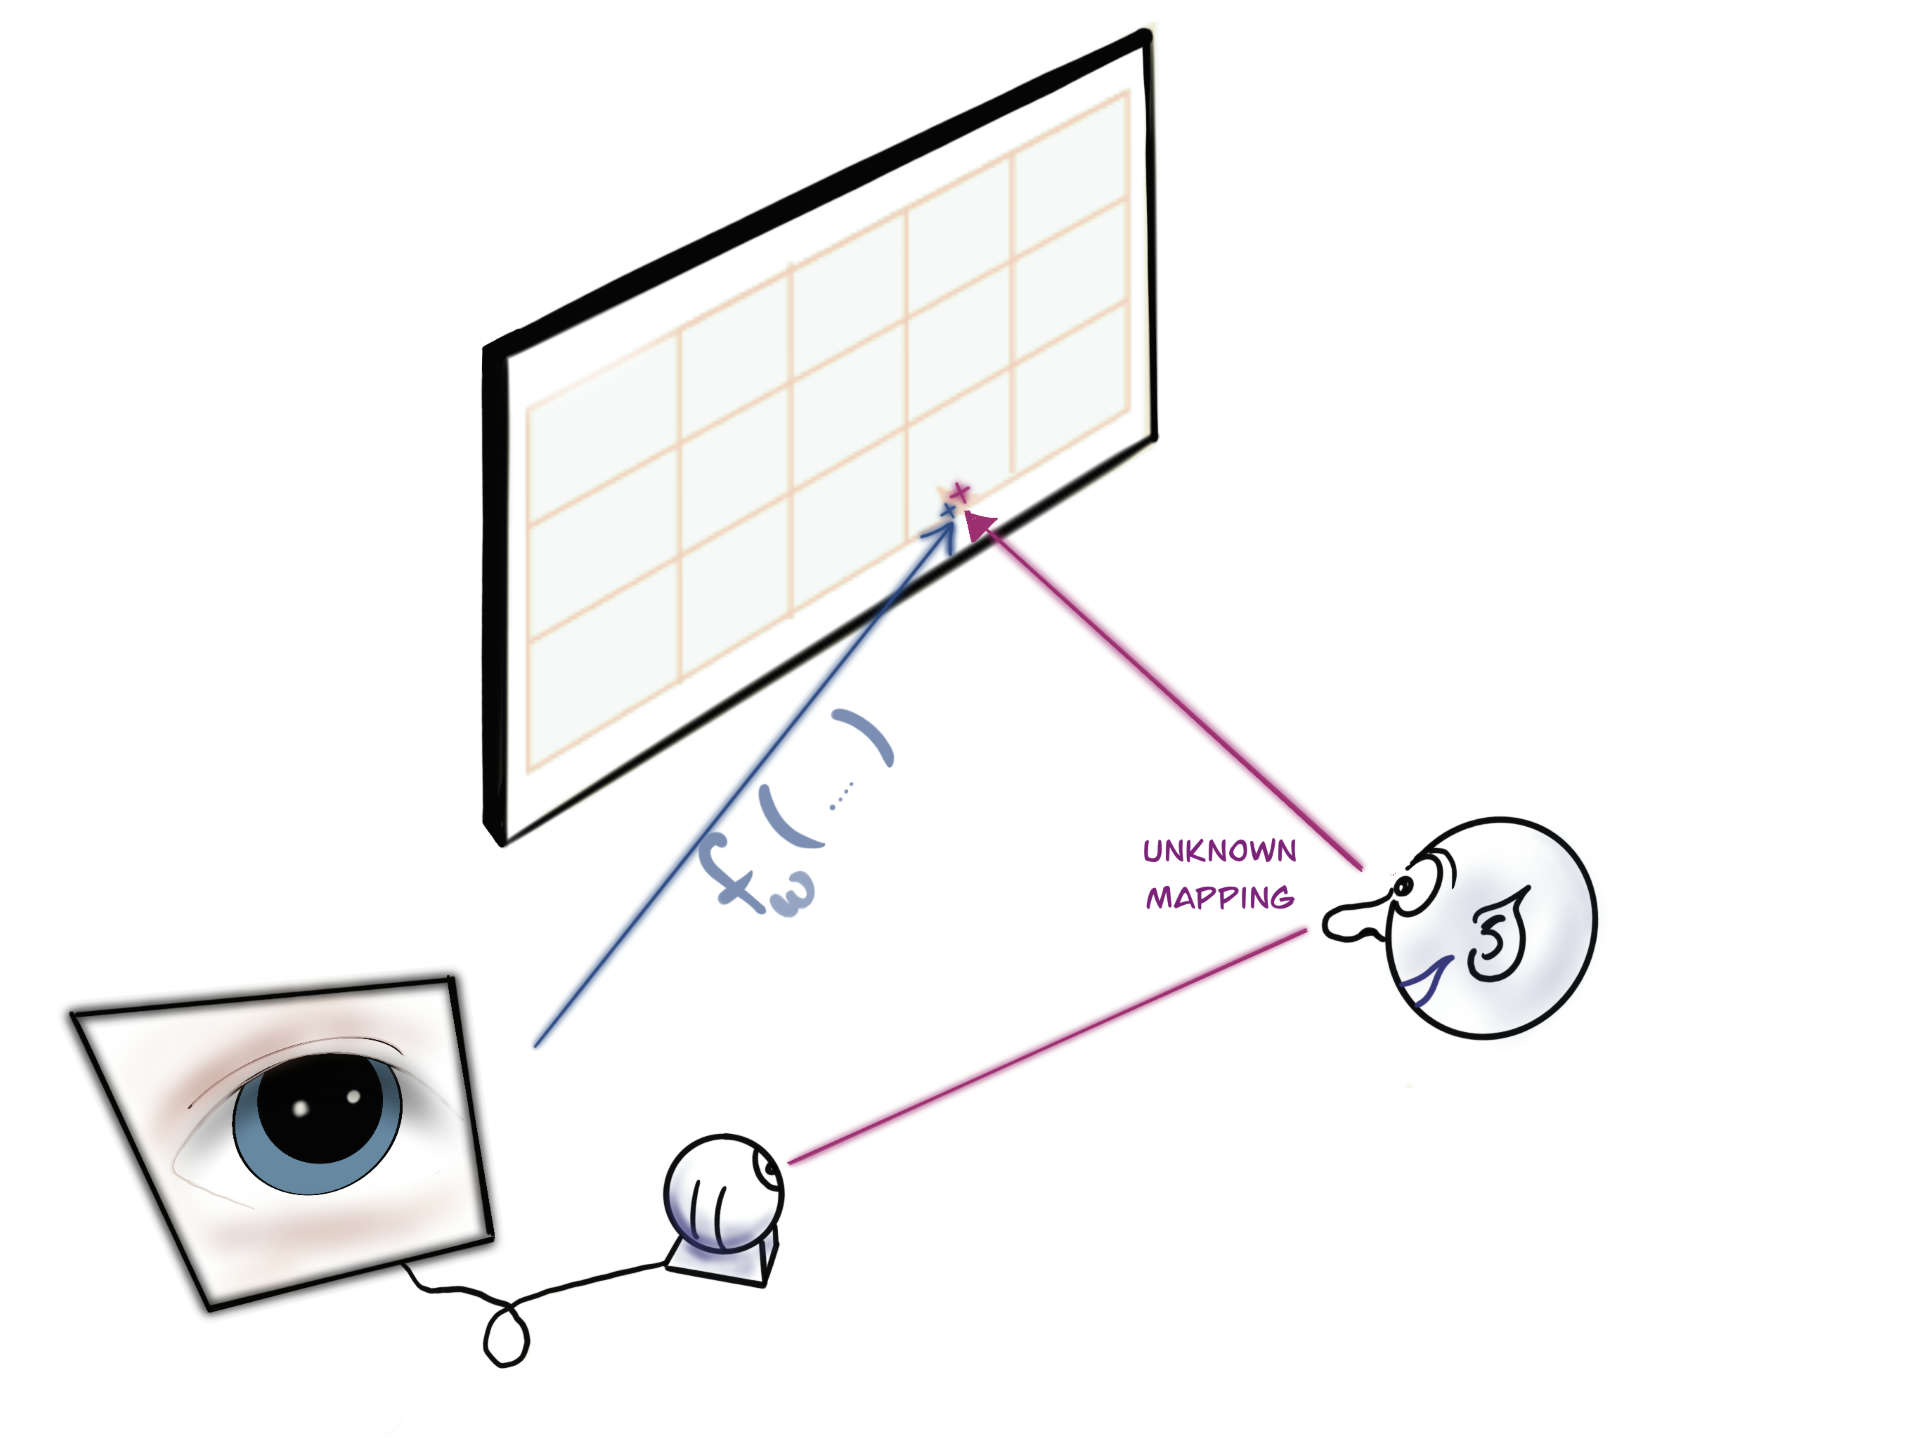

<figcaption class="figure-caption has-text-centered">Figure 2: Diagram of a gaze estimation system. The eye, which is directed at a specific point on
the screen is captured by the camera. The two red lines represent an unknown transformation from image
to eye and eye to screen. We learn this transformation directly which is shown as $f_{\mathbf{w} }(x, y)$ in the diagram.
</figcaption>
</figure>
</div>


</div>



</div>

### Gaze mapping function
The goal of this exercise is to estimate gaze from image sequences using a regression model. Define $f_{\mathbf{w}}(x, y)$ as the gaze  model which maps pupil positions $(x, y)$ to screen coordinates $(x', y')$. The model parameters $\mathbf{w}$ are learned from a training set containing paired pupil and screen positions. 
## Gaze estimation test subject 0
The first step is to train a gaze estimation model using the dataset of `test_person_0`
. You will:
- Train the models using the data `pupils_n_training`
 and `screen_coordinates_training`
. 
- Test the performance of the model using the `pupils_n_testing`
 and `screen_coordinates_testing`
. 

### Data and visualization

---
**Task 1 (easy): Data visualization👩‍💻**
1. Inspect the structure of the dataset by revisiting exercise Data preprocessing
 section _Visualization_.
2. Run the cell below to visualize the data of `test_subject_0`
.


---

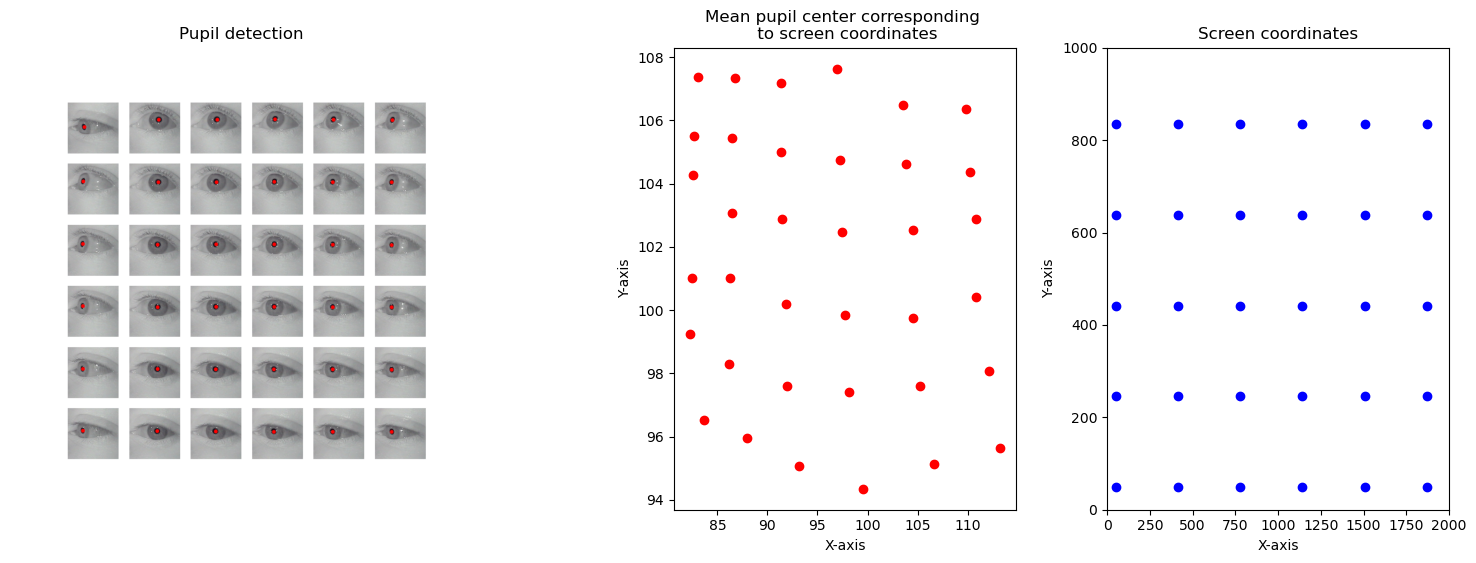

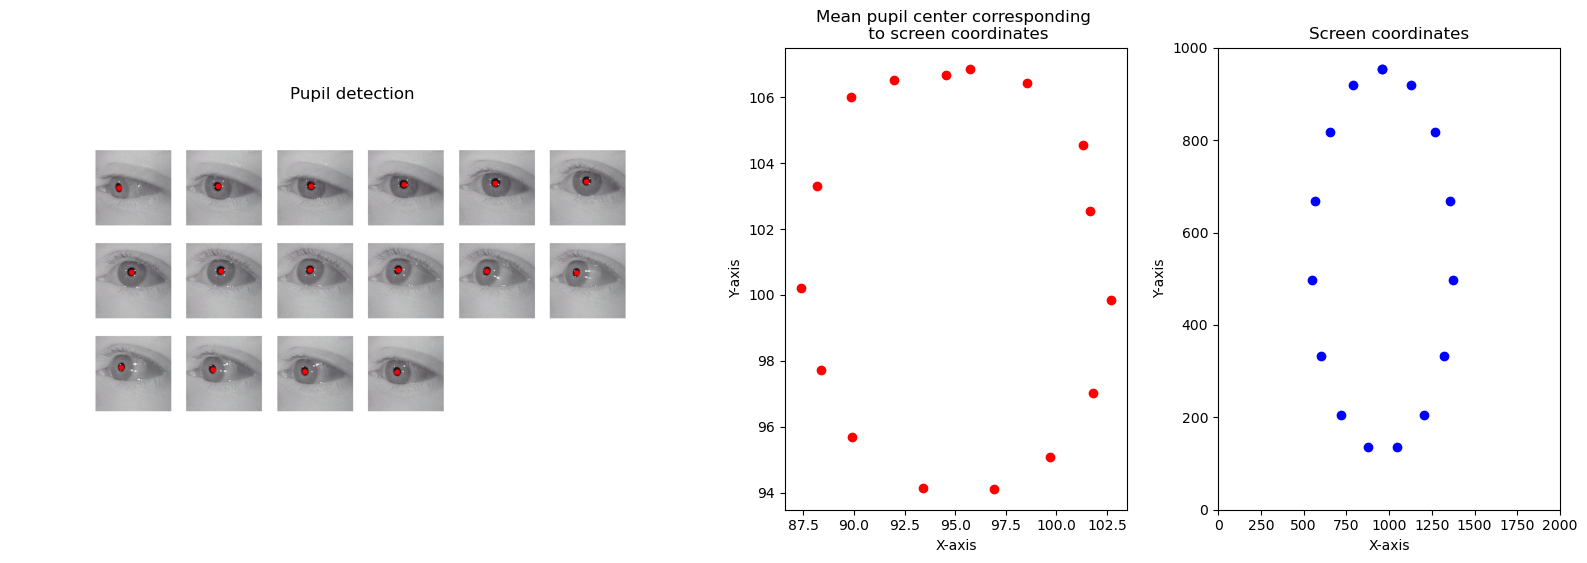

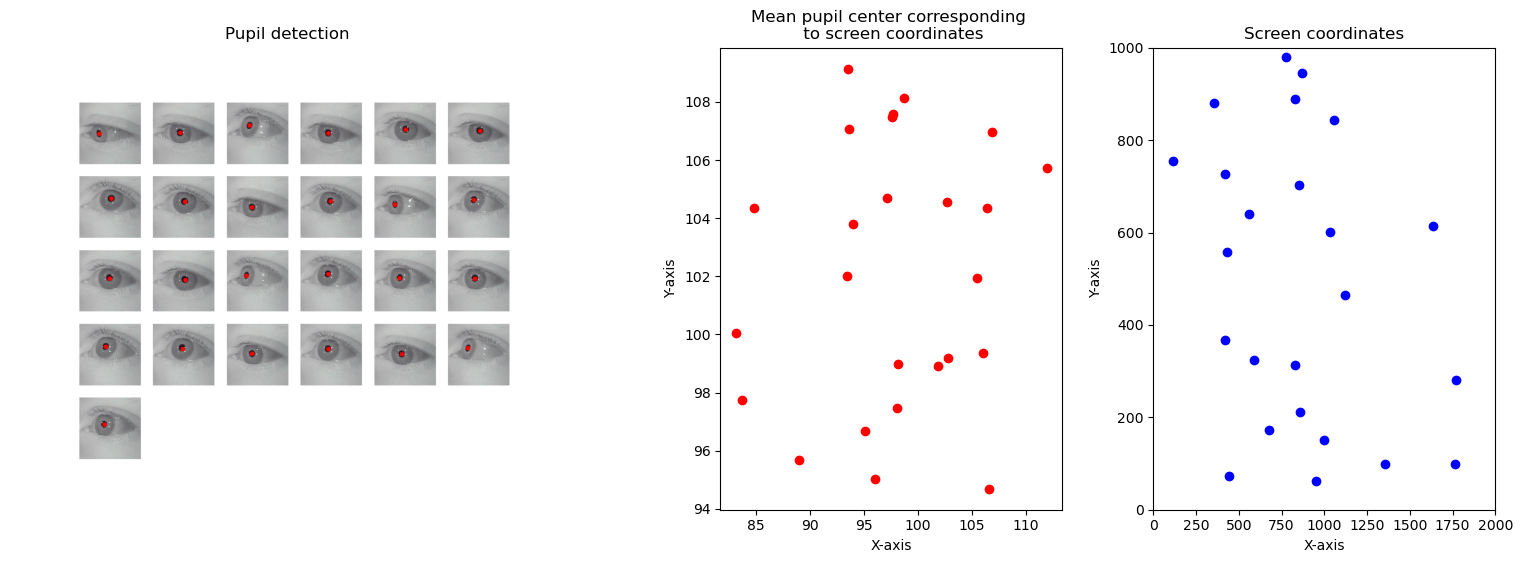

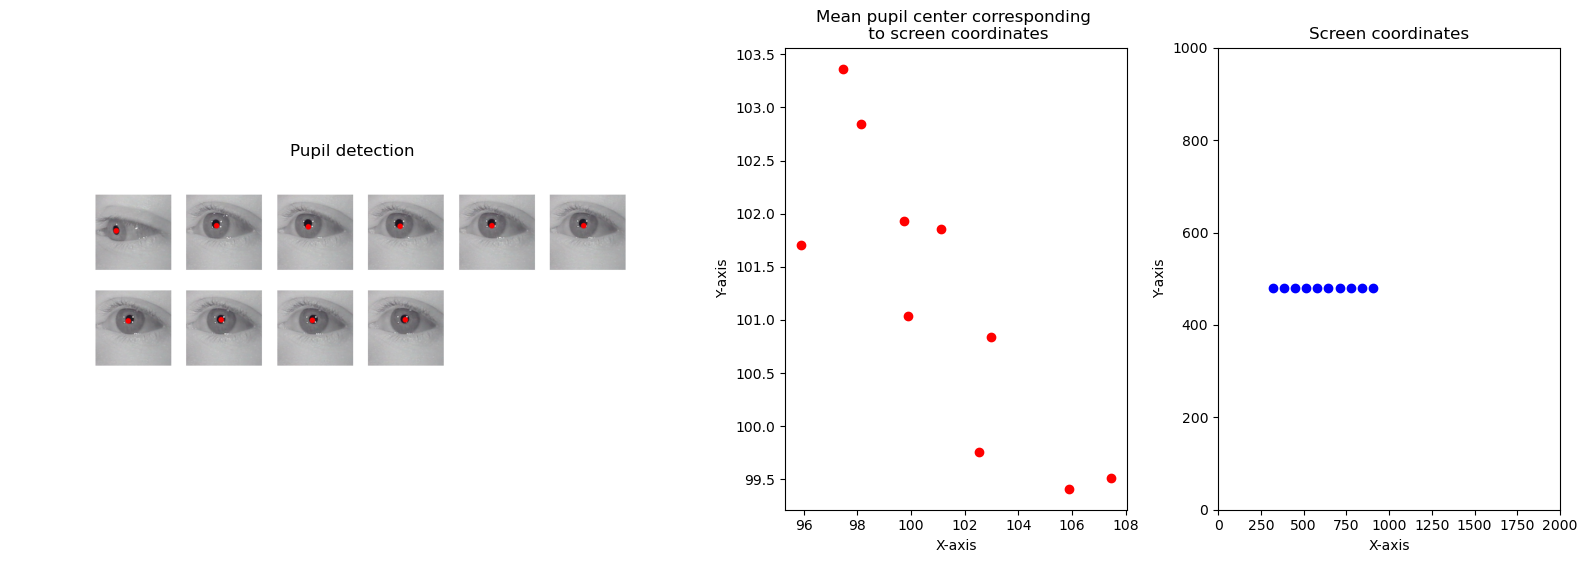

In [121]:
import os
import numpy as np
import matplotlib.pyplot as plt
import iml_util

D = iml_util.gen_data_subject_0()
for i in range(4):
    dataset = D[i]
    grid = iml_util.create_image_grid_viz(dataset)
    iml_util.image_and_scatter(grid, dataset)

## Implement a gaze estimation model
<div style="float: none; width: 100%; justify-content: start" class="block is-clearfix">

<div style="float: right; width: 25%; justify-content: start" class="block is-clearfix">

<div class="has-text-centered">
<figure class="image is-inline-block" id="gaze">

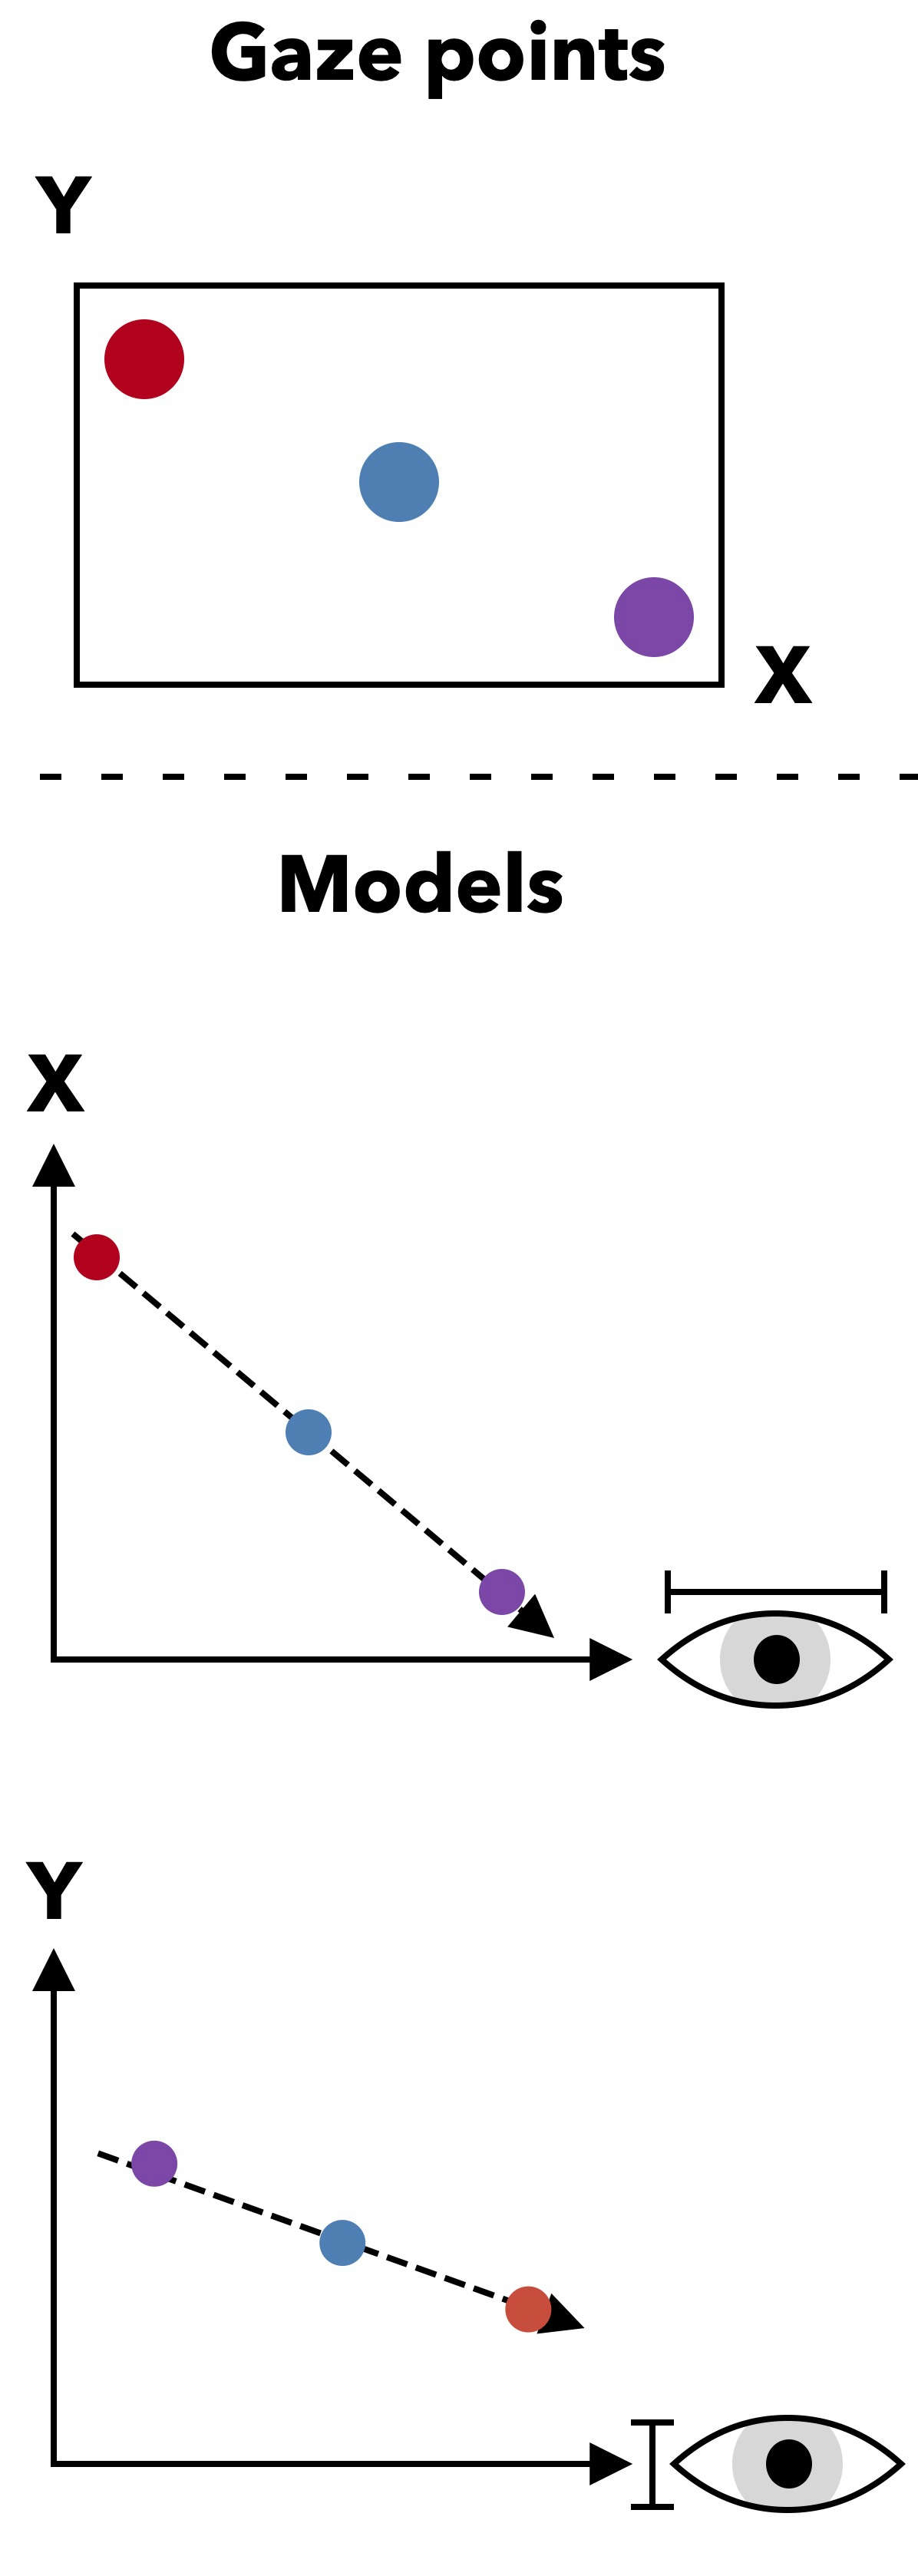

<figcaption class="figure-caption has-text-centered">Figure 3: Point mapping. Top: Three screen coordinates. Middle: Screen and eye $x$ coordinates for the same three points. Bottom: Screen and eye $y$ coordinates for the same three points.
</figcaption>
</figure>
</div>


</div>

<div style="float: left; width: 75%; justify-content: start" class="block is-clearfix">

The true nature of the function that transforms pupil positions to screen positions is not easy to model. Even when the head is stationary, the relationship between pupil position in the image and gaze is non-linear due to the pupil's movement along a spherical curve. For now, we'll approximate the gaze mapping by using a linear function. 
Since the goal is to predict a $2D$ screen coordinate from a $2D$ pupil coordinate, it's more straightforward to train two separate models for each coordinate by following the pattern of previous exercises. The linear gaze model can be expressed as:struct

$$
\begin{aligned}
x' &= ax + by + c\\
y' &= dx + ey + f.
\end{aligned}
$$
Gaze mappings is demonstrated in [Figure 3](#gaze) to the right. Here, the $x$ coordinate of the pupil maps to the $x$ coordinate on the screen. In the real model, we use both $x$ and $y$ as inputs to both models estimating the $x$ position and $y$ position on the screen.

**Hint**
Use the previous exercise
 as a guideline.

In the upcoming tasks, you will be guided through the process of identifying essential entities necessary for establishing the linear equations required to learn the model parameters of the given model. The gaze model is divided into two distinct regression models, denoted as $x' = f_{w_1}(x, y)$ and $y' = f_{w_2}(x, y)$, each associated with its unique set of model parameters $w_1$ and $w_2$. Essentially, one model predicts the value of $x'$, and the other model predicts the value of $y'$. Follow the steps outlined below for the model $x' = f_{w_1}(x, y) = ax + by + c$, and subsequently, replicate the same steps for $y'$.
1. Identify model parameters and inputs to the model. We recommended that you use Least Squares from the numpy library [linalg.lstsq](https://numpy.org/doc/stable/reference/generated/numpy.linalg.lstsq.html)
, it is recommended due to numerical stability. 
2. Isolate the unknown model parameters and the known into the design matrix.
3. Setup the linear equations $Aw=b$, where $A$ is the design matrix, $w$ the unknown model parameters and $b$ contains labels.



</div>



</div>


---
**Task 2 (medium): Initial reflection💡**
1. Identify the model parameters, inputs and outputs for the model.
2. Identify and determine the minimim number of data points needed to fit the model.
3. Using the least amount of points required to fit the model, does it matter which points are used? Why? Why not? 


---

In [122]:
#Write your reflection here...


---
**Task 3 (medium): Implement a gaze model👩‍💻**
**Note:** You can choose to train two separate models, to predict each screen coordinate separately, or you can train one model predicting both coordinates simultaniously. It may be slightly simpler to use two separate models.

1. **Design matrix:** Implement a function `get_design_matrix`
 to create the design matrix from an array pupil positions.

2. **Calibration:** Complete the implementation of the function `calibrate`
 of the class `LinearGaze`
.
    - Use the `pupils_n_train`
 and `screen_coordinates_train`
 arrays as training data. 
    - Use the function `get_design_matrix`
 to create a design matrix from the pupil positions. 
    - Learn the parameters $\mathbf{w}$ from the dataset using Least Squares. 


3. **Gaze estimation:** Finish the implementation of the function `predict`
 of the class `LinearGaze`
 which predicts the gaze point given a pupil position using the learned model parameters. For reference, the affine model has the form $f_\mathbf{w}(x)=\mathbf{w}_0 x_0 + \mathbf{w}_1 x_1 + \mathbf{w}_2$. You may calculate the point for each coordinate seperately. Return the estimated screen coordinates using the models created during calibration.


**Note:** **Important!** Don't expect the affine model to perform particularly well. Expect the distances between true and predicted gaze points to vary by $\pm 200$ pixels.


---

In [123]:
def get_design_matrix(pupil_positions):
    """
    Constructs a design matrix.
    Parameters:
    pupil_positions (N x 2 numpy array): n samples, 2 features (px, py).
    
    Returns:
    design_matrix (N x 4 numpy array) : n_samples, 2 features + 1
    
    [x, y, 1]
    
    """
    return np.c_[pupil_positions, np.ones(pupil_positions.shape[0])]

def linear(param, x):
    return param[0] + param[1]*x[0] + param[2]*x[1]

class GazeModel:
    def calibrate(self, dataset):
        ...

    def predict(self, pupil):
        ...

    def predict_many(self, pupils):
        return np.array([self.predict(pupil) for pupil in pupils])


class LinearGaze(GazeModel):
    def calibrate(self, dataset, pupil_training_set, screen_training_set):
        """
        Calibrates the LinearGaze model by fitting two linear regression models for x and y coordinates 
        based on the training dataset.

        Parameters:
            dataset (dict): The dictionary D containing the training data.
            pupil_training_set (str): Key to access the pupil training data from the dataset.
            screen_training_set (str): Key to access the screen coordinate training data from the dataset.

        Returns:
            None: Updates the model's parameters (self.model_x, self.model_y) based on the least squares solution.
        """
        # Extract the training data using the provided string keys
        pupils_train = dataset[pupil_training_set]
        screen_train = dataset[screen_training_set]
        
        # Design matrix for pupil positions
        A_design_matrix = get_design_matrix(pupils_train)
        
        # Extract screen x and y coordinates as output variables
        output_X = screen_train[:, 0]
        output_Y = screen_train[:, 1]
        
        # Use numpy's lstsq to calculate weights for both x and y coordinates
        self.model_x, _, _, _ = np.linalg.lstsq(A_design_matrix, output_X, rcond=None)
        self.model_y, _, _, _ = np.linalg.lstsq(A_design_matrix, output_Y, rcond=None)



    def predict(self, pupil):
        """
        Predicts the gaze position (x, y) based on the given pupil position using the calibrated model.

        Parameters:
            pupil (1 x 2 numpy array): 2 features (px, py) representing the current pupil position.

        Returns:
            x, y (float, float): Predicted gaze position (x, y) based on the linear model.
        """
        design_vector = np.array([pupil[0], pupil[1],1])  # px, py, bias
        #Aw = y
        #A = design matrix
        #w = model
        #y = output
        predicted_x = design_vector @ self.model_x  # Linear combination for x
        predicted_y = design_vector @ self.model_y  # Linear combination for y
        return predicted_x, predicted_y


---
**Task 4 (medium): Model evaluation👩‍💻💡**
The following task is about evaluating the performance of your models. In the following task you will complete the function `results_for_model`
. It is important that the results are calculated for the complete dataset of `test_subject_0`
 (all of $\mathcal{D}_{p0}, \mathcal{D}_{p1}, \mathcal{D}_{p2}, \mathcal{D}_{p3}$ as one dataset).
1. Finish the implementation of the function `results_for_model`
. For each dataset it must:    - **Calculate prediction errors:**         - Calculate:            - The _absolute error_ between each prediction and true gaze.
            - The _mean Eucledian distance_ between the true values and the predictions.
            - The _root-mean-square error_ (_rmse_) between the true values and the predictions.
            - The _mean absolute error_ (_mae_) as well.








---

In [124]:
import numpy as np

def results_for_model(model, dataset_train, dataset_test, pupil_training_set, screen_training_set, pupil_test_set, screen_test_set, d_max):
    """
    Evaluates the performance of the model across multiple datasets and computes prediction errors.

    Parameters:
        model (object): A gaze model object.
        dataset_train (dict): Dictionary of training data.
        dataset_test (dict): Dictionary of test data.
        pupil_training_set (str): Key for accessing pupil training set in datasets.
        screen_training_set (str): Key for accessing screen coordinate training set in datasets.
        pupil_test_set (str): Key for accessing pupil test set in datasets.
        screen_test_set (str): Key for accessing screen coordinate test set in datasets.
        d_max (int): Maximum number of patterns of a dataset to evaluate.

    Returns:
        results (dict): A dictionary where each key corresponds to a dataset index (0 to d_max-1), 
                        and each value is a dictionary containing:
            - "predicted" (N x 2 numpy array): Predicted gaze positions.
            - "ground_truth" (N x 2 numpy array): Actual gaze positions.
            - "errors" (N x 2 numpy array): Absolute errors between predicted and ground truth positions (x, y).
            - "rmse" (float): Root Mean Squared Error (RMSE) for the predictions across the dataset.
            - "dist" (float): Mean Euclidean distance between the predicted and actual positions.
            - "mae" (1 x 2 numpy array): Mean absolute error in x and y dimensions.
            - "model_x": Coefficients for x-coordinate model.
            - "model_y": Coefficients for y-coordinate model.
    """
    
    results = {}
    
    for d in range(d_max):
        # Extract training and test data for this dataset
        train_data = dataset_train[d]
        test_data = dataset_test[d]
        
        # Calibrate the model on the training data
        model.calibrate(train_data, pupil_training_set, screen_training_set)
        
        # Predict gaze positions for the test data
        predicted = model.predict_many(test_data[pupil_test_set])
        ground_truth = test_data[screen_test_set]
        
        # Calculate absolute errors
        errors = np.abs(predicted - ground_truth)
        
        # Calculate RMSE (Root Mean Squared Error)
        rmse = np.sqrt(np.mean((predicted - ground_truth) ** 2))
        
        # Calculate mean Euclidean distance between predicted and actual positions
        dist = np.mean(np.linalg.norm(predicted - ground_truth, axis=1))
        
        # Calculate Mean Absolute Error (MAE) for x and y separately
        mae = np.mean(errors, axis=0)
        
        # Store results for this dataset, including model coefficients
        results[d] = {
            "predicted": predicted,         # Store predicted values
            "ground_truth": ground_truth,   # Store ground truth values
            "errors": errors,               # Store error values
            "rmse": rmse,
            "dist": dist,
            "mae": mae,
            "model_x": model.model_x,       # Store x model coefficients
            "model_y": model.model_y        # Store y model coefficients
        }
    
    return results



def print_results_pretty(results):
    # Header
    print(f"{'Dataset':<10}{'RMSE':<10}{'Mean Distance':<15}{'MAE (X)':<10}{'MAE (Y)':<10}")
    print("-" * 50)
    
    # Print each result in the table
    for dataset, metrics in results.items():
        rmse = metrics["rmse"]
        dist = metrics["dist"]
        mae_x = metrics["mae"][0]
        mae_y = metrics["mae"][1]
        
        print(f"D{dataset:<9}{rmse:<10.2f}{dist:<15.2f}{mae_x:<10.2f}{mae_y:<10.2f}")


# Example usage
results_linear = results_for_model(LinearGaze(), D, D, 'pupils_n_train', 'screen_coordinates_train', 'pupils_n_test', 'screen_coordinates_test', 4)

print_results_pretty(results_linear)


Dataset   RMSE      Mean Distance  MAE (X)   MAE (Y)   
--------------------------------------------------
D0        126.85    165.62         146.19    63.13     
D1        98.95     134.17         115.10    60.91     
D2        72.92     96.46          57.62     64.51     
D3        94.84     122.52         62.93     92.17     


Below you find a cell containing a function for visualizing the performance of the model. 

---
**Task 5 (medium): Visualize performance of your model👩‍💻**
1. **Create visualizations:** Run the cell below to visualiz the performance of the model for all patterns using the function `plot_results_grid`
 from `iml_util.py`
. The function takes a dictionary of results as well as the number of patterns in the dictionary. Combined they provide an overview of the nature of the error across the two dimensions.


---

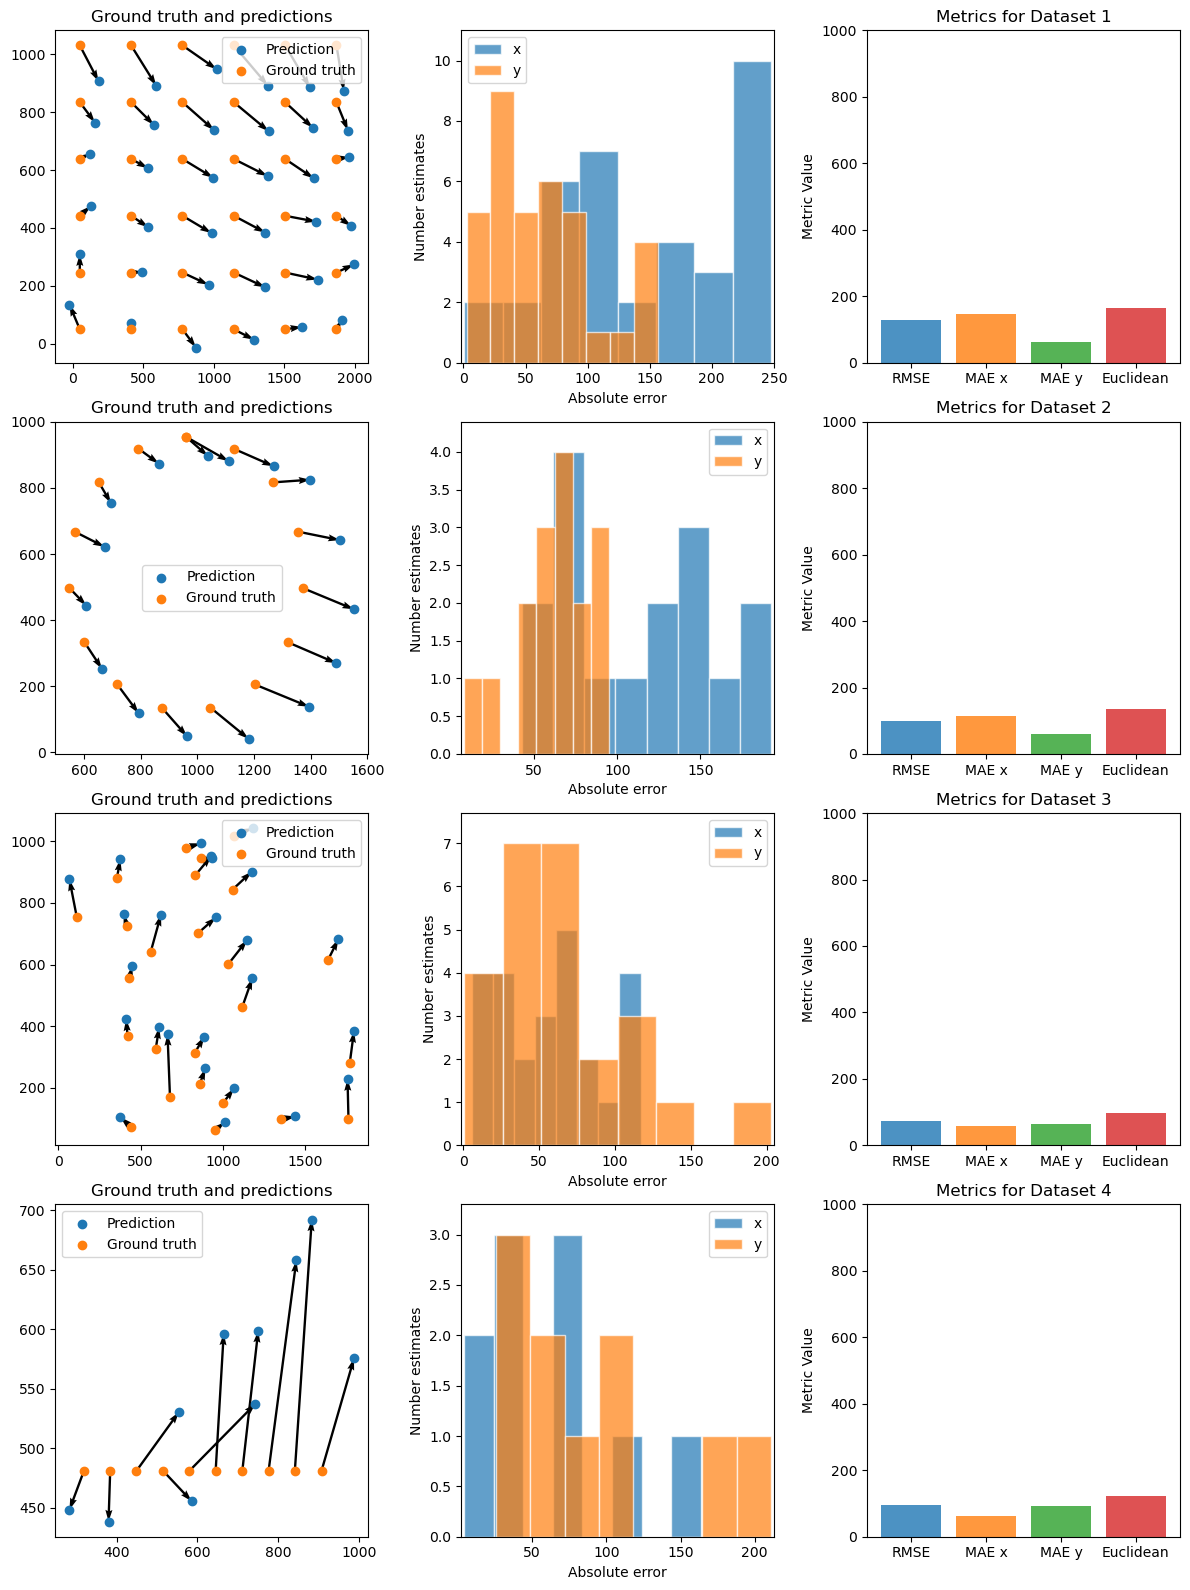

In [125]:
iml_util.plot_results_grid(results_linear, 4)


---
**Task 6 (medium): Evaluate performance of your model💡**
1. Evaluate the usefulness of the _mae_ or _rmse_ and their differences.
2. Identify at least 3 potential sources of error associated with the current affine model. Describe how each source of error contributes to the prediction error.


---

In [126]:
'''
GPT - TODO LØS OG REFLEKTER SELV.

1. Evaluate the Usefulness of MAE or RMSE and Their Differences:
MAE (Mean Absolute Error):

Interpretation: MAE provides an average of the absolute differences between the predicted and actual values. It measures the average magnitude of the errors in a set of predictions, without considering their direction.
Usefulness: MAE is useful when you want a simple, intuitive measure of the average error in predictions. It is easy to interpret as it gives the actual units of the output variable. MAE is not sensitive to outliers, meaning that large errors won't disproportionately affect the metric.
RMSE (Root Mean Square Error):

Interpretation: RMSE squares the differences before averaging, which gives more weight to larger errors. This makes RMSE sensitive to outliers or large differences between predicted and actual values.
Usefulness: RMSE is preferred when large errors are particularly undesirable, as it will penalize those heavily. If your model's performance is measured on minimizing extreme differences, RMSE can provide better insight.
Comparison:

MAE gives a linear score which means all individual differences are equally weighted. On the other hand, RMSE gives a quadratic score, giving more weight to large errors.
RMSE is generally larger than MAE unless all errors have the same magnitude. The difference between RMSE and MAE can also indicate the presence of outliers (i.e., when RMSE is significantly larger, it suggests that some large errors are present).
Use Case:

If you care about the general performance across all predictions equally, use MAE.
If large deviations are costly in your context and must be minimized, RMSE should be the preferred metric.
2. Identify 3 Potential Sources of Error in the Current Affine Model:
Simplified Linear Model:

Description: The affine model assumes a simple linear relationship between pupil positions and screen coordinates, which may not capture the true complexity of the gaze estimation process. In reality, eye movements are nonlinear, and factors such as head tilt or eye curvature can cause deviations from the linear relationship.
Impact: This simplification can introduce significant prediction errors when the real mapping deviates from linearity. This leads to higher RMSE and MAE, particularly when the pupil positions are farther from the calibrated range.
Limited Training Data:

Description: If the model is trained on a limited or biased dataset (e.g., only certain parts of the screen or specific lighting conditions), it may fail to generalize to unseen or diverse gaze positions.
Impact: Poor generalization can result in higher errors when the test data contains gaze points that differ significantly from those seen during training. The model's inability to generalize well outside its trained region contributes to larger prediction discrepancies.
Noise and Variability in Pupil Detection:

Description: The process of detecting the pupil center is susceptible to errors due to various factors such as lighting changes, reflections, or imperfect detection algorithms. Even small inaccuracies in detecting the pupil position can translate to significant errors in gaze prediction.
Impact: These small inaccuracies or noise in the pupil detection system propagate through the affine model, leading to unpredictable errors in the predicted screen coordinates. Since the model assumes that pupil detection is precise, these errors can cause large deviations, reflected in both RMSE and MAE metrics.

'''

"\nGPT - TODO LØS OG REFLEKTER SELV.\n\n1. Evaluate the Usefulness of MAE or RMSE and Their Differences:\nMAE (Mean Absolute Error):\n\nInterpretation: MAE provides an average of the absolute differences between the predicted and actual values. It measures the average magnitude of the errors in a set of predictions, without considering their direction.\nUsefulness: MAE is useful when you want a simple, intuitive measure of the average error in predictions. It is easy to interpret as it gives the actual units of the output variable. MAE is not sensitive to outliers, meaning that large errors won't disproportionately affect the metric.\nRMSE (Root Mean Square Error):\n\nInterpretation: RMSE squares the differences before averaging, which gives more weight to larger errors. This makes RMSE sensitive to outliers or large differences between predicted and actual values.\nUsefulness: RMSE is preferred when large errors are particularly undesirable, as it will penalize those heavily. If your 

You have now went through the first part of the assignment processing the session of `test_subject_0`
. The remaining part of the assignment use the same approach as you have just gone through with the purpose of you working with and reflecting on the use of your own data collected. 
## Test on test subject 3
In the data processing exercise Data preprocessing
 the pupil corrdinates `mean_pupil_coordinates.csv`
 and the corresponding screen coordinates `screen_coordinates.csv`
 were saved in the in the folder with the test subjects and patterns. Recall the four calibration patterns used for the data collection being **grid**, **circle**, **line** and **random**.
In this exercise you will use the calibration (training data) of `test_subject_0`
 on the data from `test_subject_3`
 and visualized in [Figure 4](#calibration).
<div style="float: none; width: 100%; justify-content: start" class="block is-clearfix">

<div class="has-text-centered">
<figure class="image is-inline-block" id="calibration">

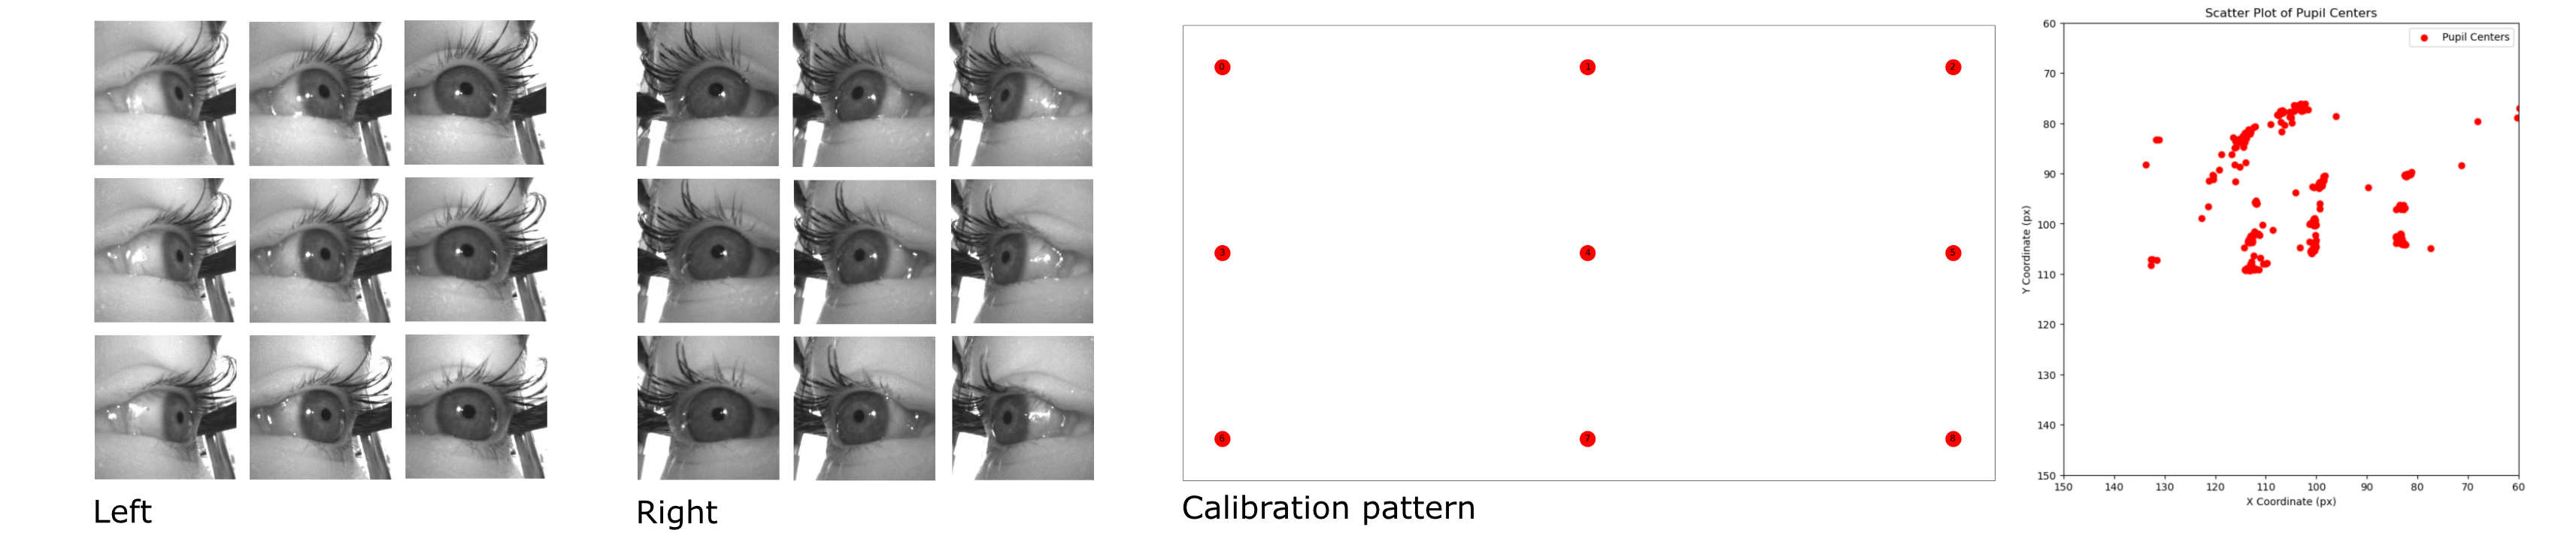

<figcaption class="figure-caption has-text-centered">Figure 4: Left: Images fron calibration pattern grid. Middle: Calibration pattern. Right: Pupil center scatterplot from calibration pattern grid.</figcaption>
</figure>
</div>


</div>


---
**Task 7 (easy): Load the data👩‍💻**
1. Run the cell below to load the data of `test_subject_3`
. _Similarily_ to the data of `test_subject_0`
 meaning that the `grid`
 pattern is defined as training set for all other patterns. The data is stored as a list of dictionaries in the following order: `grid`
, `circle`
, `line`
, and `random`
. Within each dictionary you find: 


**Details about the data format of `test_subject_3`**
**Dataset elements:**
- `pupils_train`
: Mean pupil positions for the 9 calibration points from `grid`
 pattern (an $9 \times 2$ array containing the x and y coordinates (`px`
, `py`
)).
- `screen_coordinates_train`
: Screen target positions for the 9 calibration points from `grid`
pattern ($9 \times 2$ array containing x,y pixel position for the target on the screen (`sx`
, `sy`
)).
- `pupils_test`
: Mean pupil positions for the calibration points for the pattern accociated as the key(an $N \times 2$ array containing the $N$ x and y coordinates (`px`
, `py`
)).
- `screen_coordinates_train`
: Screen target positions for the N calibration points associated to the pattern defined as the key ($N \times 2$ array containing the $N$ x andy pixel positions for the target on the screen (`sx`
, `sy`
))



---

In [127]:
D3 = iml_util.gen_data_subject('test_subject_3')


---
**Task 8 (easy): Visualize performance👩‍💻**
1. Run the cell blow to evaluate the gaze estimation model using the `pupils_grid`
 data from `test_subject_3`



---

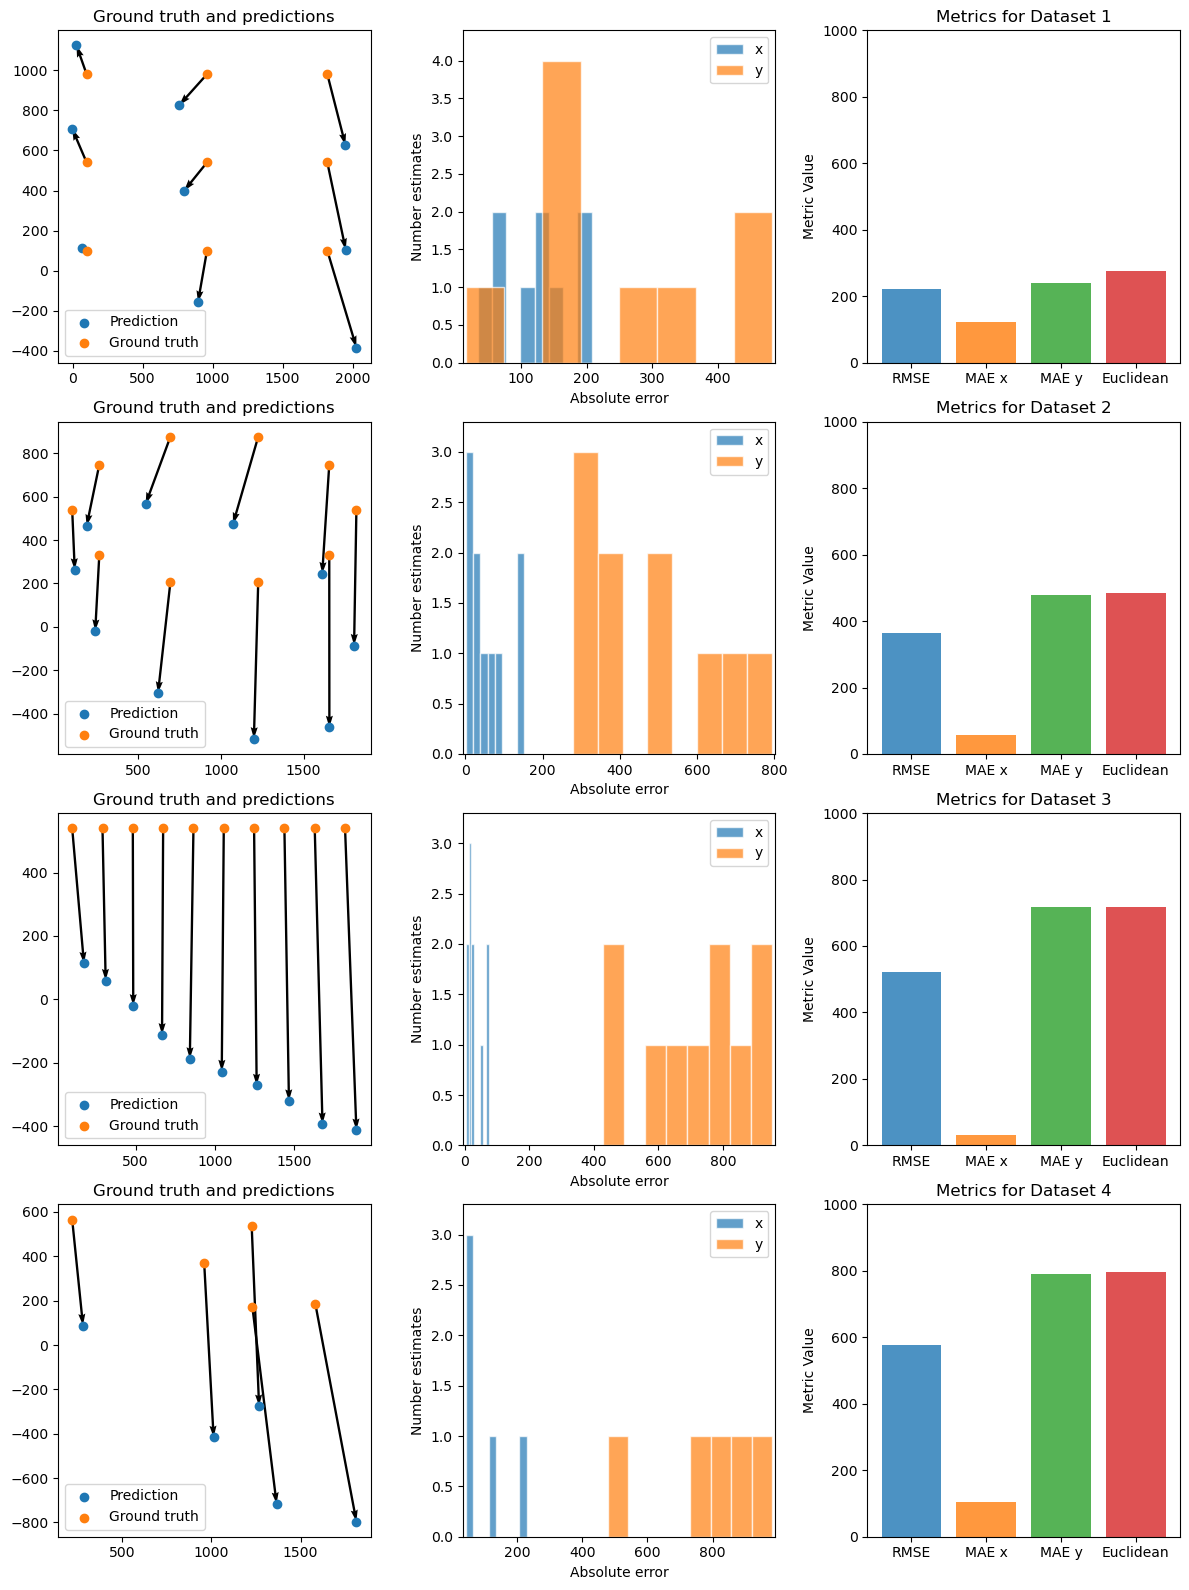

In [128]:
results_linear_ts3 = results_for_model(LinearGaze(), D, D3, 'pupils_n_train', 'screen_coordinates_train', 'pupils_test', 'screen_coordinates_test', 4)

iml_util.plot_results_grid(results_linear_ts3, 4)


---
**Task 9 (medium): Evaluation♾️💡**
You likely have observed larger prediction errors, including the `MAE_y`
 and `RMSE`
. Reflect on:
1. How well does the model predict gaze of `test_subject_3`
?
2. Use your reflections in Task 8 in the exercise Data preprocessing
 to elaborate on the results in this exercise.
3. Comment on differences between the predicted `x`
 and `y`
 coordinate.


---

In [129]:
#Write your reflections here...

''' GPT - TODO LAV OG REFLEKTER SELV.
1. Model Prediction Performance for Test Subject 3:
The plots clearly show a notable difference between the predicted gaze positions and the ground truth for test_subject_3.
Observation:
The model struggles to provide accurate gaze predictions, especially for the y coordinate. The quiver plots, which show the difference between predictions and ground truth, depict large gaps in both x and y dimensions, but the y errors are particularly pronounced. This suggests that the model's ability to map pupil positions to gaze points in the y direction is less effective than for the x direction.
Both RMSE and MAE_y values are high, indicating that the model has difficulty minimizing the errors in these dimensions for test_subject_3. This is likely due to the affine nature of the model, which might oversimplify the mapping between pupil movements and gaze locations.
2. Reflections Based on Task 8 (Data Preprocessing):
Impact of Data Preprocessing:
From Task 8, data preprocessing (e.g., normalization, filtering out noise in pupil positions) is crucial. Without sufficient preprocessing, noise or outliers in pupil position data can significantly affect the predictions. In this case, it is possible that the data for test_subject_3 contains noise that wasn't adequately filtered during preprocessing, leading to the larger errors we observe.
The fact that MAE_y is consistently higher across datasets might suggest that the preprocessing steps (such as detecting pupil centers) were more effective for the x coordinate than for y. There could be physiological or technical factors (e.g., uneven lighting affecting the y-axis more) that contribute to this discrepancy.
Potential Model Over-Simplification:
The affine model assumes a linear mapping between pupil positions and gaze coordinates, which likely underfits the actual complexity of the problem. As test_subject_3 might have more varied pupil movements or screen distances than the training data, the model cannot capture the full range of non-linearities. Thus, more advanced models (e.g., nonlinear or polynomial mappings) could improve predictions for both x and y coordinates.
3. Differences Between Predicted X and Y Coordinates:
Error Disparities:
Across all datasets, there is a noticeable difference between the errors for the x and y coordinates. The MAE_y is consistently larger than MAE_x, indicating that the model predicts x coordinates more accurately than y.
Why This Happens: This could be due to several reasons:
Model Simplicity: The affine model may oversimplify the mapping for y coordinates more than for x, as vertical eye movements can involve more complex muscle movements and nonlinearities.
Pupil Detection Noise: The pupil tracking system might have a systematic bias when detecting the vertical (y-axis) position of the pupil, resulting in larger errors for the y predictions.
Physiological Factors: Human eye movements might naturally vary more in the vertical direction than in the horizontal one, making it harder for the model to predict y accurately.
Conclusion: The consistent gap between x and y errors suggests that further refinement is needed either in the preprocessing phase (e.g., better calibration for vertical gaze points) or in adopting a more sophisticated, nonlinear model.
Summary:
The test_subject_3 predictions reveal significant prediction errors, especially for the y coordinate, with high MAE_y and RMSE values. These large errors likely stem from both data preprocessing issues and the affine model's limitations in capturing the complexity of gaze patterns.

'''

" GPT - TODO LAV OG REFLEKTER SELV.\n1. Model Prediction Performance for Test Subject 3:\nThe plots clearly show a notable difference between the predicted gaze positions and the ground truth for test_subject_3.\nObservation:\nThe model struggles to provide accurate gaze predictions, especially for the y coordinate. The quiver plots, which show the difference between predictions and ground truth, depict large gaps in both x and y dimensions, but the y errors are particularly pronounced. This suggests that the model's ability to map pupil positions to gaze points in the y direction is less effective than for the x direction.\nBoth RMSE and MAE_y values are high, indicating that the model has difficulty minimizing the errors in these dimensions for test_subject_3. This is likely due to the affine nature of the model, which might oversimplify the mapping between pupil movements and gaze locations.\n2. Reflections Based on Task 8 (Data Preprocessing):\nImpact of Data Preprocessing:\nFrom T

## Gaze estimation test subject 3
In this the gaze estimation model is trained using the `grid`
 pattern of `test_subject_3`
, and test it on the patterns. 

---
**Task 10 (easy): Train and test a model👩‍💻**
1. Use `result_for_model`
 to train and test a gaze estimation model based on `test_subject_3`
.
2. Use `plot_results_grid`
 to visualize the result.

**Note:** The result using pupil centers from the `grid`
 pattern is a result of training and testing on the same data.


---

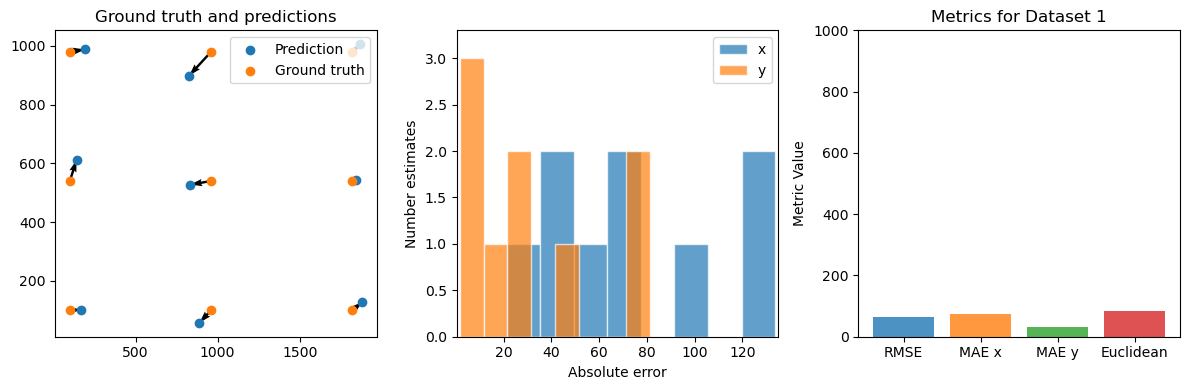

In [130]:
# Assuming D3 is a list of dictionaries where the first entry (index 0) is the 'grid' pattern
grid_data_train = D3[0]  # Training data for the grid pattern
grid_data_test = D3[0]  # Since training and testing are on the same data

# Train and test using the result_for_model function
results_grid = results_for_model(
    model=LinearGaze(),                      # Your gaze estimation model
    dataset_train=[grid_data_train],          # Training data (list of dictionaries)
    dataset_test=[grid_data_test],            # Test data (list of dictionaries)
    pupil_training_set='pupils_train',        # Key for pupil positions in the training data
    screen_training_set='screen_coordinates_train',  # Key for screen coordinates in the training data
    pupil_test_set='pupils_test',             # Key for pupil positions in the test data
    screen_test_set='screen_coordinates_test',  # Key for screen coordinates in the test data
    d_max=1                                   # Only testing on the grid pattern (1 dataset)
)

# Visualize the results using the plot_results_grid function
iml_util.plot_results_grid(results_grid, 1)




---
**Task 11 (easy): Evaluation💡**
1. Reflect on the result testing the model on `test_subject_3`
.     - Use your reflection from Task 8 in exercise Data preprocessing
 to elaborate on the result.        - Why does the performance of the model trained on `test_subject_3`
 show significantly larger prediction errors compared to the one trained and tested on `test_subject_0`
?






---

In [131]:
''' TODO - GPT, erstat med egen løsning of refleksion.
Question: Why does the performance of the model trained on test_subject_3 show significantly larger prediction errors compared to the one trained and tested on test_subject_0?

Reflection:
Differences in Data Preprocessing (Task 8 Insights):

In test_subject_0, preprocessing may have involved steps such as normalization, filtering out noisy data, or handling outliers that helped the model perform better. If test_subject_3 did not undergo the same level of preprocessing, noise in the pupil positions (px, py) could have introduced larger errors.
Additionally, any inconsistencies in lighting conditions, head position, or calibration precision during the recording for test_subject_3 could have further degraded performance, leading to poorer results.
Model's Generalization:

The affine model used for gaze estimation assumes a simple linear relationship between pupil positions and screen coordinates. This assumption might hold better for test_subject_0, especially if that subject's data was well-represented during the training phase.
For test_subject_3, the model likely struggles with generalization. If the pupil movements or gaze patterns differ significantly from those seen during training, the model may not adapt well, resulting in larger errors in predictions.
Subject-Specific Physiological Differences:

Each test subject might exhibit different eye movement patterns, such as the extent of horizontal vs. vertical movements or how smoothly the eye tracks across the screen. The differences between test_subject_0 and test_subject_3 could be large enough that a model trained on one would perform poorly on the other.
Physiological differences, such as how each subject focuses on a target or their individual pupil dynamics, can affect gaze estimation accuracy. For example, test_subject_3 might have more rapid or jerky eye movements, leading to larger prediction errors compared to the smoother eye movements of test_subject_0.
Training vs. Testing Conditions:

If test_subject_3's training and testing conditions differed significantly (e.g., lighting, screen distance, or pupil detection quality), this could contribute to the model's reduced accuracy. Models perform better when trained and tested in similar conditions.
Additionally, the fact that the same data was used for training and testing on test_subject_0 would naturally result in lower error metrics, as the model has effectively "memorized" the training data. When tested on an entirely new subject (i.e., test_subject_3), the model's limitations in generalizing become apparent.
Summary:
The model performs significantly worse on test_subject_3 compared to test_subject_0 due to a combination of factors such as noise in data preprocessing, differences in gaze patterns, and the model’s inability to generalize well across different subjects. Physiological and environmental factors also play a crucial role, along with potential overfitting to test_subject_0 during training.
'''

' TODO - GPT, erstat med egen løsning of refleksion.\nQuestion: Why does the performance of the model trained on test_subject_3 show significantly larger prediction errors compared to the one trained and tested on test_subject_0?\n\nReflection:\nDifferences in Data Preprocessing (Task 8 Insights):\n\nIn test_subject_0, preprocessing may have involved steps such as normalization, filtering out noisy data, or handling outliers that helped the model perform better. If test_subject_3 did not undergo the same level of preprocessing, noise in the pupil positions (px, py) could have introduced larger errors.\nAdditionally, any inconsistencies in lighting conditions, head position, or calibration precision during the recording for test_subject_3 could have further degraded performance, leading to poorer results.\nModel\'s Generalization:\n\nThe affine model used for gaze estimation assumes a simple linear relationship between pupil positions and screen coordinates. This assumption might hold b

You may by now you have observed that the model is struggling with properly predicting the `y`
 coordinates. The cell below visualizes the model predictions separating the `x`
 and `y`
 coordinate.

---
**Task 12 (easy): Evaluation(continued)♾️💡**
1. Run the cell below to viualize the models independently. 
2. Use the plot for further evaluation, reflect on the questions:    - Observe that the model are struggling the most in predicting the `y`
 coordinate correctly. What is a possible explanation for this? 
    - What would happen to the plane if we train the model on more data points?



**Note:** Incoorporate your reflections from exercise Data preprocessing
 Task 8.


---

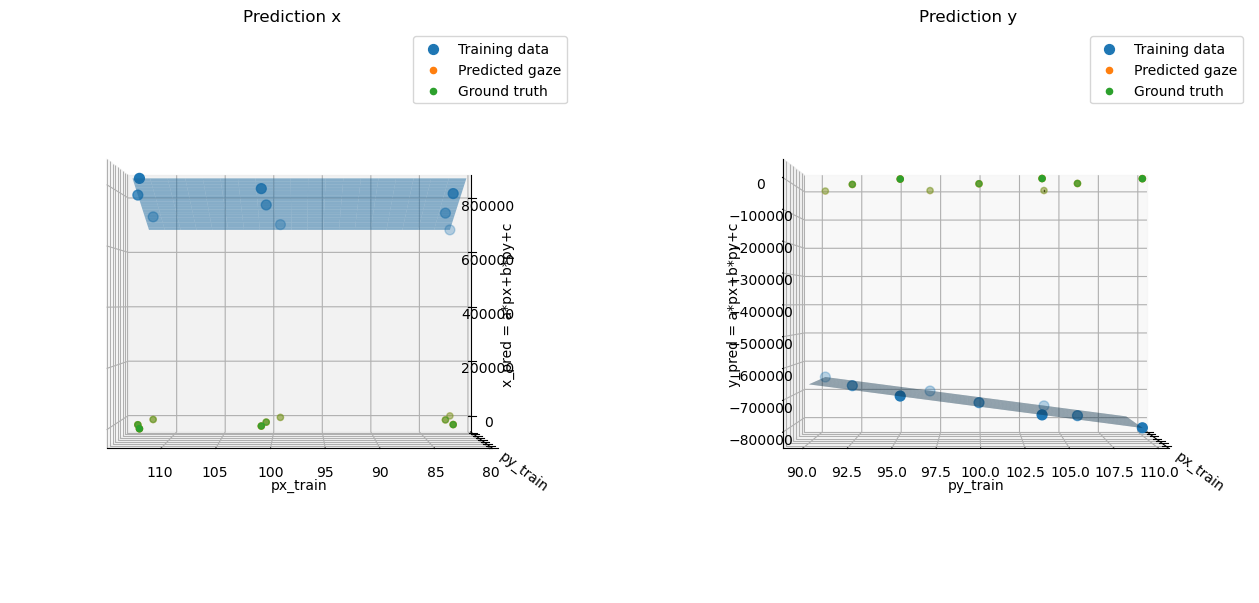

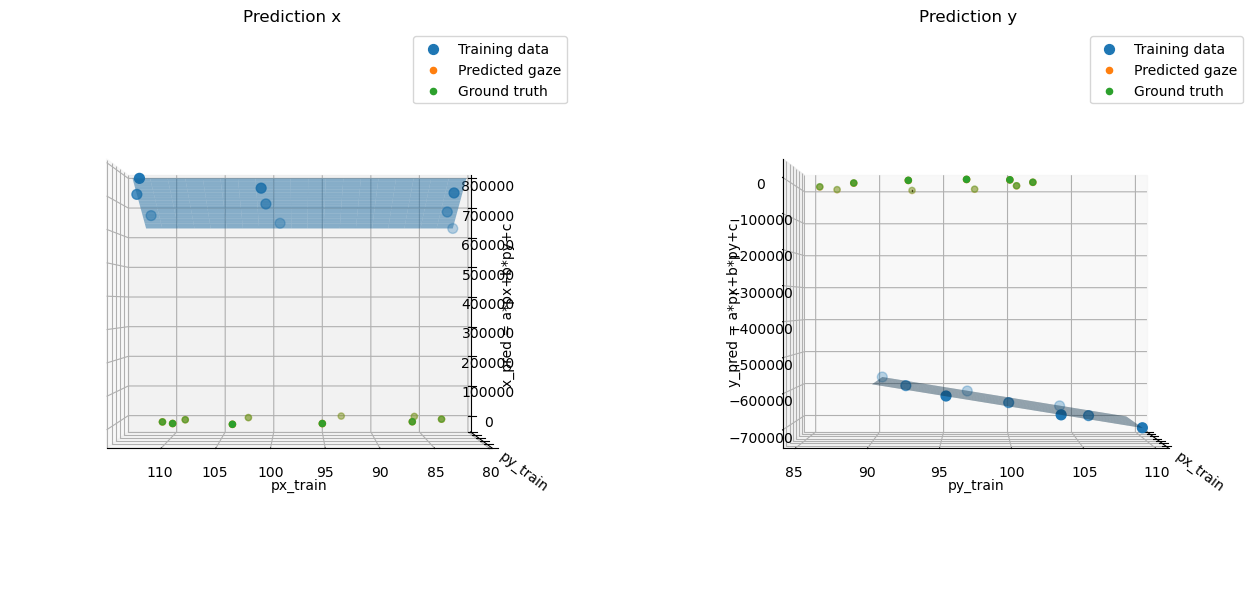

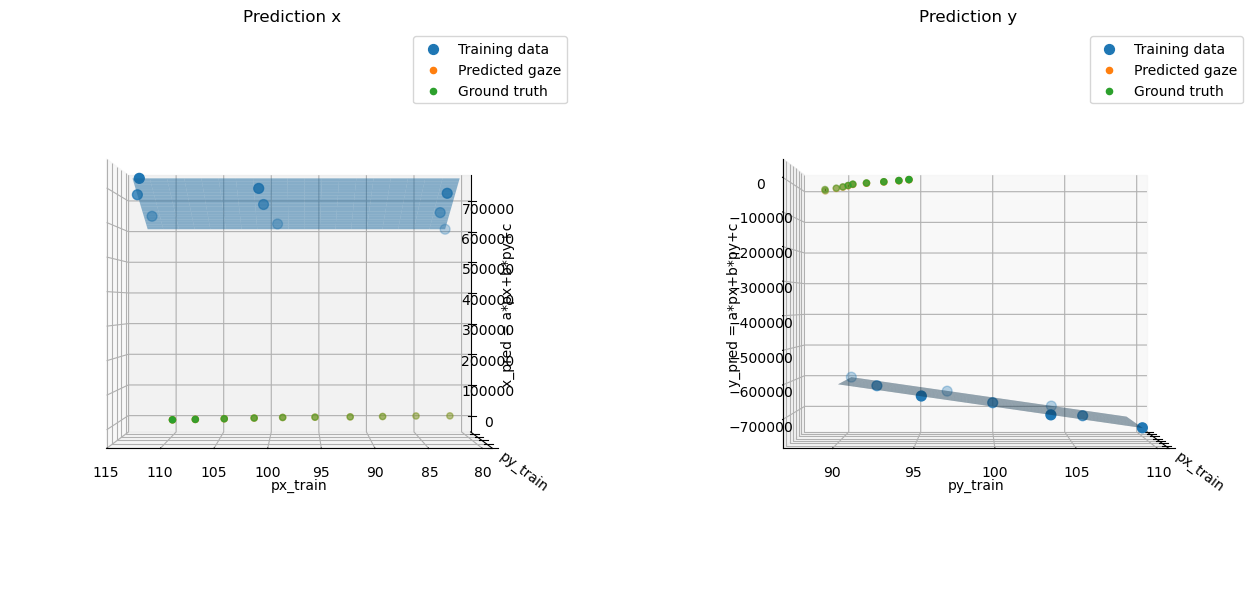

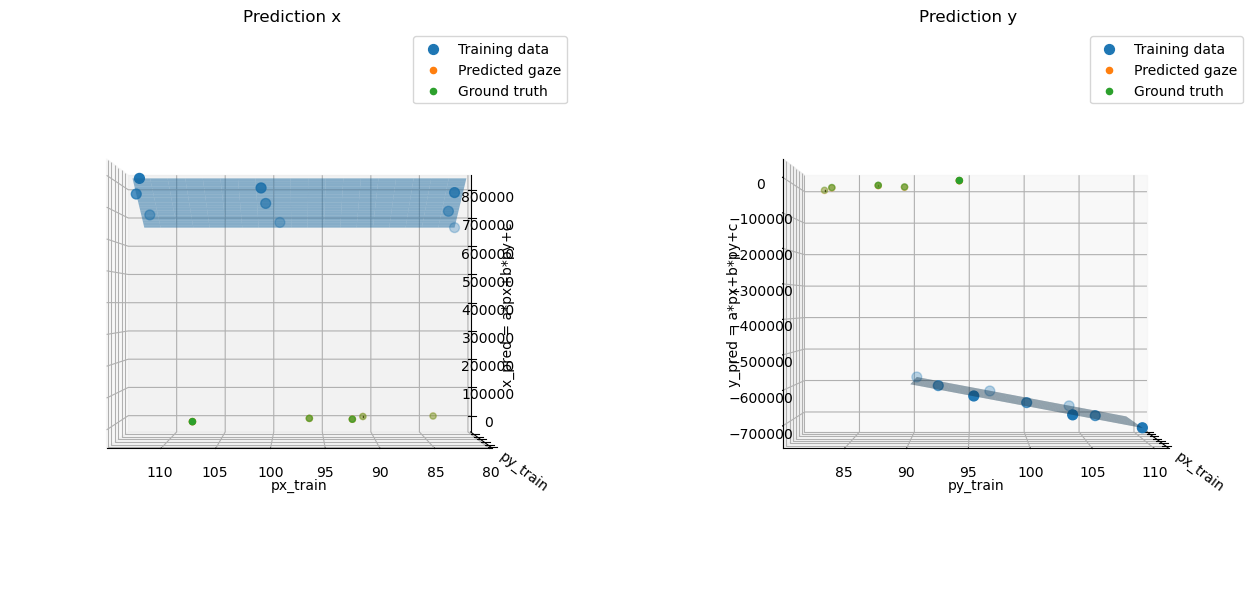

In [132]:
for i in range(len(results_linear_ts3)):
    iml_util.plot_from_results_dict(results_linear_ts3[i], D3[i])

## task 12 answer TODO, LAV EGET SVAR

1. Observation:
The model struggles most in predicting the y coordinate, as evidenced by the earlier plots showing misaligned predictions and larger errors for the y values compared to the x values.

2. Possible Explanation for Poor Y-Coordinate Predictions:
Linear Model Inadequacy: The model used is affine, meaning it assumes a simple linear relationship between pupil positions and gaze coordinates. The y-axis might require a more complex model, potentially nonlinear, due to the physiological characteristics of eye movements in the vertical direction. Vertical eye movements can involve more complex and varied muscle activity, leading to less predictable results with a linear model.
Training Data Bias: If the y-axis data points from the training set are not well-distributed or if they don't represent the full range of vertical movements, the model may have been trained on biased data, resulting in poor generalization to new y positions.
Physiological Variability: There might be inherent variability in how different subjects' eyes move vertically. Eye movements along the y axis could be less consistent across different subjects compared to the x axis, leading to higher errors when the model is applied to unseen subjects.
3. Impact of Training on More Data Points:
If the model were trained on more data points that better capture the full range of pupil movements (especially along the y axis), it is likely that the model could better generalize and predict gaze points more accurately.
Training on a more diverse set of y values would allow the model to "learn" a broader range of pupil movements, reducing bias and overfitting to specific regions of the data space.

To further elaborate on the prediction of the `y`
coordinate, the cell below visualizes the  _Sum of Squared Error_ (SSE) loss function, in parameter space. 
The cell below creates two plots, left is the loss when changing parameters `a`
 and `b`
 while keeping  `c`
 fixed. The right plot shows loss when varying `c`
 while keeping `a`
 and `b`
 fixed.

---
**Task 13 (easy): Evaluation(continued)♾️💡**
1. Run the cell below to visualize the loss described by the parameters. 
2. Describe the effect each parameter has on the SSE.


---

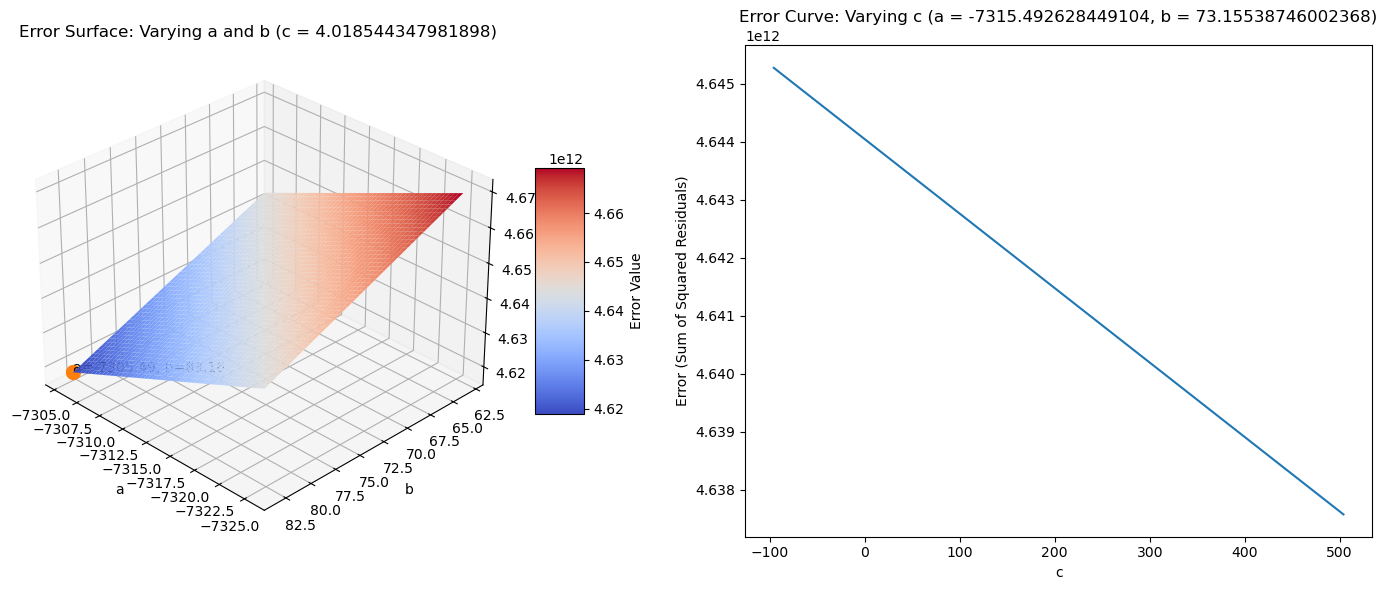

In [133]:
# Example usage with sample data
x = D3[0]['pupils_train'][:,0]
y = D3[0]['pupils_train'][:,1]
z = D3[0]['screen_coordinates_train'][:,1]  # Actual targets

# Set fixed values for a, b, and c (based on an example linear model)
a_fixed = results_linear_ts3[0]['model_y'][2]
b_fixed = results_linear_ts3[0]['model_y'][1]
c_fixed = results_linear_ts3[0]['model_y'][0]

# Plot the error surfaces
iml_util.plot_error_surfaces(a_fixed, b_fixed, c_fixed, x, y, z)

In [134]:
'''
TODO SVAR SELV.

Task 12: Evaluation of the Model's Struggles in Predicting the Y Coordinate
1. Observation:
The model struggles most in predicting the y coordinate, as evidenced by the earlier plots showing misaligned predictions and larger errors for the y values compared to the x values.

2. Possible Explanation for Poor Y-Coordinate Predictions:
Linear Model Inadequacy: The model used is affine, meaning it assumes a simple linear relationship between pupil positions and gaze coordinates. The y-axis might require a more complex model, potentially nonlinear, due to the physiological characteristics of eye movements in the vertical direction. Vertical eye movements can involve more complex and varied muscle activity, leading to less predictable results with a linear model.
Training Data Bias: If the y-axis data points from the training set are not well-distributed or if they don't represent the full range of vertical movements, the model may have been trained on biased data, resulting in poor generalization to new y positions.
Physiological Variability: There might be inherent variability in how different subjects' eyes move vertically. Eye movements along the y axis could be less consistent across different subjects compared to the x axis, leading to higher errors when the model is applied to unseen subjects.
3. Impact of Training on More Data Points:
If the model were trained on more data points that better capture the full range of pupil movements (especially along the y axis), it is likely that the model could better generalize and predict gaze points more accurately.
Training on a more diverse set of y values would allow the model to "learn" a broader range of pupil movements, reducing bias and overfitting to specific regions of the data space.
Task 13: Evaluation of SSE and Parameter Effects
The final plot visualizes how the Sum of Squared Errors (SSE) changes when the parameters of the linear model (a, b, and c) are varied.

1. Effect of Parameters on SSE:
Left Plot (Error Surface with Varying a and b):
The error surface is relatively flat in some regions, which indicates that varying a and b does not significantly affect the error in certain ranges.
However, there's a clear gradient towards smaller errors in specific regions, suggesting that some combinations of a and b lead to better fits than others. The slope of the surface shows that certain values of a and b (in the range of -7320 to -7315 for a, and 65 to 75 for b) result in better performance, while other combinations yield higher SSE values.
Right Plot (Error Curve Varying c):
The error decreases steadily as c increases, indicating that the parameter c has a significant influence on reducing the overall SSE. This suggests that adjusting the intercept of the model (which c represents) is crucial for achieving better predictions and minimizing error.
2. Interpretation of Each Parameter’s Effect on the SSE:
Parameter a: Controls how much the x coordinate of the pupil affects the gaze position. The error surface shows that small changes in a can lead to moderate changes in SSE, but there is a region of optimal values.
Parameter b: Controls how much the y coordinate of the pupil affects the gaze position. Its effect on SSE is similar to a in that certain values produce smaller errors.
Parameter c: Acts as the intercept in the linear model and significantly affects the error. As the right-side plot indicates, increasing c consistently decreases the SSE, showing that c plays a critical role in minimizing prediction errors.
3. Overall Conclusion:
The c parameter (intercept) has the most pronounced impact on reducing the error, as seen in the error curve.
Both a and b also affect the SSE, but the error surface suggests that there's more flexibility in choosing values for a and b as long as they remain within a certain range.
For improved accuracy in y predictions, careful tuning of b and c would be essential, as these parameters are closely tied to the vertical component of gaze estimation.
'''

'\nTODO SVAR SELV.\n\nTask 12: Evaluation of the Model\'s Struggles in Predicting the Y Coordinate\n1. Observation:\nThe model struggles most in predicting the y coordinate, as evidenced by the earlier plots showing misaligned predictions and larger errors for the y values compared to the x values.\n\n2. Possible Explanation for Poor Y-Coordinate Predictions:\nLinear Model Inadequacy: The model used is affine, meaning it assumes a simple linear relationship between pupil positions and gaze coordinates. The y-axis might require a more complex model, potentially nonlinear, due to the physiological characteristics of eye movements in the vertical direction. Vertical eye movements can involve more complex and varied muscle activity, leading to less predictable results with a linear model.\nTraining Data Bias: If the y-axis data points from the training set are not well-distributed or if they don\'t represent the full range of vertical movements, the model may have been trained on biased da


---
**Task 14 (hard): Evaluation(continued)♾️💡**
1. Observe that it appears as the prediction could benefit from a smaller value of `c`
 thank the least square model learned. Reflect on why this occurs.    - Why might adjusting the slope be more important for reducing the overall error?
    - How might this affect the optimization of $c$ compared to $a$ and $b$ when there is a large scale difference between inputs and labels?



**Note:** Hint: The model minimizes the total error by adjusting the parameters. Changing `a`
 and `b`
 affects how well the slope fits the data trend, while `c`
 just shifts the plane. 
The model tries to minimize the sum of squared errors $\sum \left( z - (ax + by + c) \right)^2$. If $x$ and $y$ are much smaller in scale than $z$, the terms $a \cdot x$ and $b \cdot y$ contribute less to the error than $c$.


---

In [135]:
#Write your reflections here...

'''
TODO LAV SELV

Task 14: Reflection on the Importance of Slope and Intercept Adjustment in Error Minimization
1. Why might adjusting the slope be more important for reducing the overall error?
Effect of the Slope (a and b): The slope parameters (a and b) control how much the input variables (x and y) affect the predicted output (z). Changing the slope alters the tilt or angle of the plane in the 3D space (pupil coordinates to screen coordinates). This adjustment is important because a poor slope can cause the predicted values to deviate drastically from the ground truth, especially if the inputs vary widely.
SSE Minimization: When the slope is incorrect, the difference between the predicted plane and the actual values grows significantly as the input variables change. Therefore, adjusting the slope has a profound effect on reducing the overall error by better aligning the model's predictions with the observed data.
2. How might this affect the optimization of c compared to a and b when there is a large scale difference between inputs and labels?
Scale Disparity Between Inputs and Labels: If the input variables (x and y) are much smaller in scale compared to the output (z), the contributions of the terms a * x and b * y to the prediction will be much smaller than c (the intercept). In such a case, the model can achieve a lower error by focusing on adjusting c, which simply shifts the entire plane up or down without affecting the tilt.
Optimization of c: When the scale of z is much larger than x and y, the intercept c plays a dominant role in determining the model's predictions, as it controls the vertical offset of the plane. Adjusting c can result in a significant reduction in error, as small adjustments in a and b will have relatively little effect due to the small magnitude of x and y. This explains why the error surfaces show that varying c has a much larger impact on minimizing SSE compared to adjusting a and b.
3. Reflection on the Influence of c vs. a and b:
Intercept Dominance: In cases where the inputs (x and y) are small compared to the output (z), the intercept c essentially becomes a dominating factor in reducing error. The model compensates for the large difference between inputs and outputs by shifting the plane vertically through changes in c, while the slopes a and b contribute less to minimizing the error.
Slope Contribution: If x and y values are relatively small, changes in a and b lead to minor tilts in the prediction plane. These small tilts have a limited effect on reducing the overall error, especially if the ground truth values of z have a larger range. Therefore, the optimization process focuses more on finding the best c to minimize SSE, as shifting the plane up or down produces a more immediate reduction in the error.
Summary:
Adjusting a and b affects how well the slope of the plane fits the data, but when x and y are much smaller in magnitude than z, changes in a and b have less influence on reducing the total error.
In such scenarios, the intercept c plays a dominant role in minimizing the SSE by shifting the entire plane vertically, compensating for the scale difference between inputs and outputs. Therefore, the model is more sensitive to changes in c than in a and b when trying to reduce the error.
'''

"\nTODO LAV SELV\n\nTask 14: Reflection on the Importance of Slope and Intercept Adjustment in Error Minimization\n1. Why might adjusting the slope be more important for reducing the overall error?\nEffect of the Slope (a and b): The slope parameters (a and b) control how much the input variables (x and y) affect the predicted output (z). Changing the slope alters the tilt or angle of the plane in the 3D space (pupil coordinates to screen coordinates). This adjustment is important because a poor slope can cause the predicted values to deviate drastically from the ground truth, especially if the inputs vary widely.\nSSE Minimization: When the slope is incorrect, the difference between the predicted plane and the actual values grows significantly as the input variables change. Therefore, adjusting the slope has a profound effect on reducing the overall error by better aligning the model's predictions with the observed data.\n2. How might this affect the optimization of c compared to a an

Until now the models have been trained using the nine calibration points from the `grid`
 pattern. You will now increase the amount of training data by incoorporating all patterns except `circle`
. The pattern `circle`
 will be used for testing. In the cell below a dictionary `D3_mod`
 contains the training and test data similar to the structure of `D`
and `D3`
. . 

---
**Task 15 (medium): Adding more data♾️💡**
1. Use the function`results_for_model`
 and the `LinearGaze`
 class to train a new model using `D3_mod`
. Use `plot_results_grid`
 to visualize the results and the function `plot_from_results_dict`
 to visualize the models.
2. Run the cell below to train and test the model and visualize the result. 


---

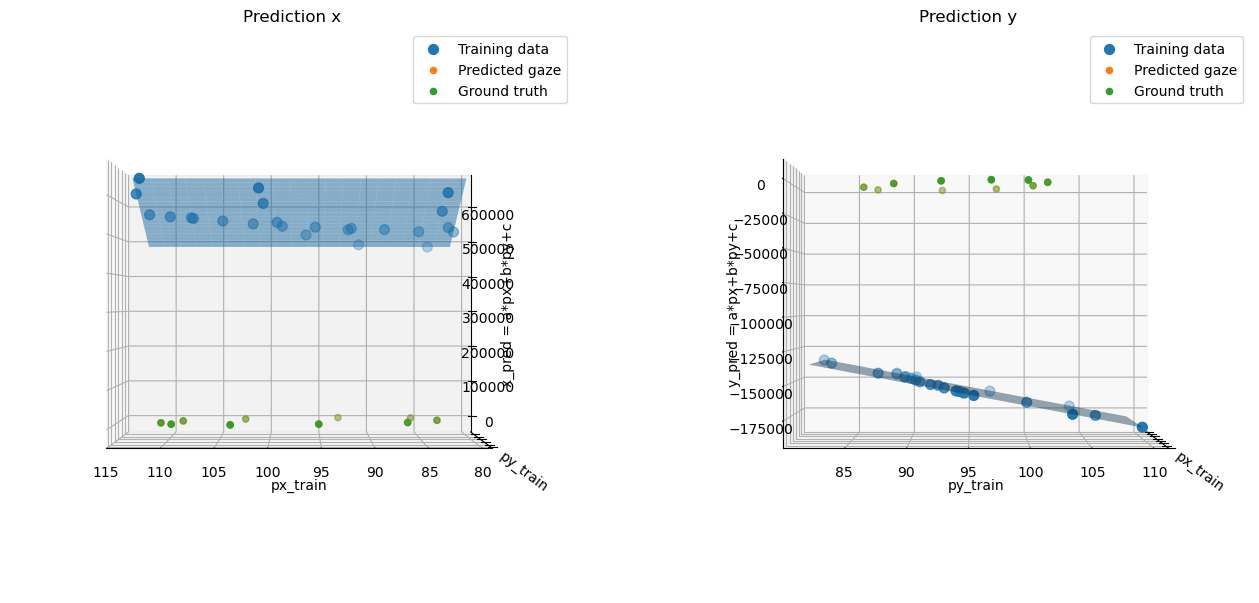

In [136]:
D3_mod = {}

ts3_p_train = D3[0]['pupils_test']
ts3_s_train = D3[0]['screen_coordinates_test'] 

ts3_p_test = D3[1]['pupils_test']
ts3_s_test = D3[1]['screen_coordinates_test']

for i in range(2,4):
    ts3_p_train = np.vstack((ts3_p_train,D3[i]['pupils_test']))
    ts3_s_train = np.vstack((ts3_s_train,D3[i]['screen_coordinates_test']))
    
D3_mod['pupils_train'] = ts3_p_train
D3_mod['screen_coordinates_train'] = ts3_s_train
D3_mod['pupils_test'] = ts3_p_test
D3_mod['screen_coordinates_test'] = ts3_s_test

D3_mod = [D3_mod]

# Write your code here

# Train and test the model using the combined data in D3_mod
results_mod = results_for_model(
    model=LinearGaze(),  # Your gaze model
    dataset_train=D3_mod,  # Training data (D3_mod has combined data)
    dataset_test=D3_mod,  # Testing data (circle pattern)
    pupil_training_set='pupils_train',
    screen_training_set='screen_coordinates_train',
    pupil_test_set='pupils_test',
    screen_test_set='screen_coordinates_test',
    d_max=1  # Only 1 dataset in D3_mod
)

# Visualize the results using plot_from_results_dict
iml_util.plot_from_results_dict(results_mod[0], D3_mod[0])



---
**Task 16 (medium): Evaluate♾️💡**
1. How does adding more training data affect the results.    - Does increasing the amount of training data _always_ improve the model's accuracy?
    - How does the variability in the data affect the model's ability to generalize when more data is added (elaborate on your reflection from Task 2.3)?
    - How could adding more data influence the optimization of the model parameters?




---

In [137]:
'''
TODO LAV SELV.

Task 16: Evaluation
1. How does adding more training data affect the results?
Positive Impact of More Training Data: Adding more training data generally improves the model's performance because the model gets exposed to more variations and patterns in the data. By training on multiple patterns (grid, line, random), the model has more information about how different pupil positions relate to screen coordinates, which can help it generalize better to unseen data.

Observation: In the plots, we can see that although the x predictions are still misaligned with the ground truth, the overall error may have been reduced due to the added variability in training. More diverse training data can allow the model to learn a better slope or intercept that applies across different gaze patterns.

Caveat: However, increasing the amount of data doesn’t always improve accuracy. If the added data is noisy, biased, or irrelevant, it could degrade model performance. Also, if the underlying assumptions of the model (such as linearity) are incorrect, adding more data will not fix the fundamental issues with the model structure.

2. How does variability in the data affect the model’s ability to generalize?
Variability Helps Generalization: Adding variability in the data (from different patterns like grid, line, random) increases the model's ability to generalize because it learns from a wider range of pupil positions and screen coordinates. Instead of overfitting to one specific pattern, the model learns a broader mapping between pupil positions and gaze points, making it more likely to work well on unseen data.

Reflection: As seen in earlier tasks, when the model was trained on fewer patterns, it likely overfitted to specific ranges of data. This led to poor performance when tested on different patterns. By incorporating data from multiple patterns, the model's performance should improve for diverse inputs, although, in this case, the predictions still struggle to match the ground truth perfectly.

3. How could adding more data influence the optimization of the model parameters?
Impact on Model Parameter Optimization: When more data is added, the model’s parameters (a, b, and c) are likely to converge to values that minimize the error across all the training patterns. The added data helps the optimization process by providing more evidence for the model to adjust its slopes and intercepts. Specifically, the model can better estimate the overall trend in the data, rather than just fitting to one specific subset.

Reflection on Task 2.3: In Task 2.3, we discussed that the affine model could struggle due to its simplistic linear assumptions. While adding more data helps reduce errors, it may not fully fix the model’s inability to capture nonlinear patterns in eye movements, particularly for the y coordinate, as evidenced by the persistent misalignment between the predictions and ground truth. Therefore, while adding data helps, the fundamental limitations of the model may still prevent it from fully optimizing its parameters for perfect predictions.

Summary:
Adding more training data generally improves the model by allowing it to generalize better across different patterns.
Increased variability in the data allows the model to learn a broader relationship between inputs (pupil positions) and outputs (screen coordinates), improving its robustness to unseen data.
While more data can help refine the model's parameters, it may not fully resolve issues if the model’s structure (such as linearity assumptions) is fundamentally inadequate for the complexity of the problem.

'''

"\nTODO LAV SELV.\n\nTask 16: Evaluation\n1. How does adding more training data affect the results?\nPositive Impact of More Training Data: Adding more training data generally improves the model's performance because the model gets exposed to more variations and patterns in the data. By training on multiple patterns (grid, line, random), the model has more information about how different pupil positions relate to screen coordinates, which can help it generalize better to unseen data.\n\nObservation: In the plots, we can see that although the x predictions are still misaligned with the ground truth, the overall error may have been reduced due to the added variability in training. More diverse training data can allow the model to learn a better slope or intercept that applies across different gaze patterns.\n\nCaveat: However, increasing the amount of data doesn’t always improve accuracy. If the added data is noisy, biased, or irrelevant, it could degrade model performance. Also, if the 

## Individual dataset
The pipeline of collecting data, training a model, testing, and evaluating it has been introduced. In this task, the data of your eyes will be used to train a model. Use the evaluation tools introduced in the assignment.
**Note:** **Important!** In case you do **not** want to share your data with the TA's for assessment, train and evaluate the models using your data and place images of the evaluation in the folder `data/output/individual`
. Comment out the coding cells for this part of the assigment for handin to allow TA's to run the entire notebook without errors, c.f. submitting details on [About the course](https://iml.itu.dk/01-about_the_course/01-AboutTheCourse.html)
. Submit the assignment without the data folder containing your data, and refer to evaluation images by name in your reflections.


---
**Task 17 (easy): Individual dataset**
1. For reproduceability, write the _threshold_, _x_margin_, _y_margin_ and _side_ values that was used in the processing your data in Task 4 of the  Data preprocessing
 exercise.


---

In [138]:
#Note the values here
# Threshold = 
# x_margin = 
# y_margin = 
# side =


---
**Task 18 (medium): Train and test a model**
1. Run the cell below to generate a dictionary of your own data.
2. Train an affine gaze estimation model using the pattern `grid`
.
3. Test the model on  all patterns.


---

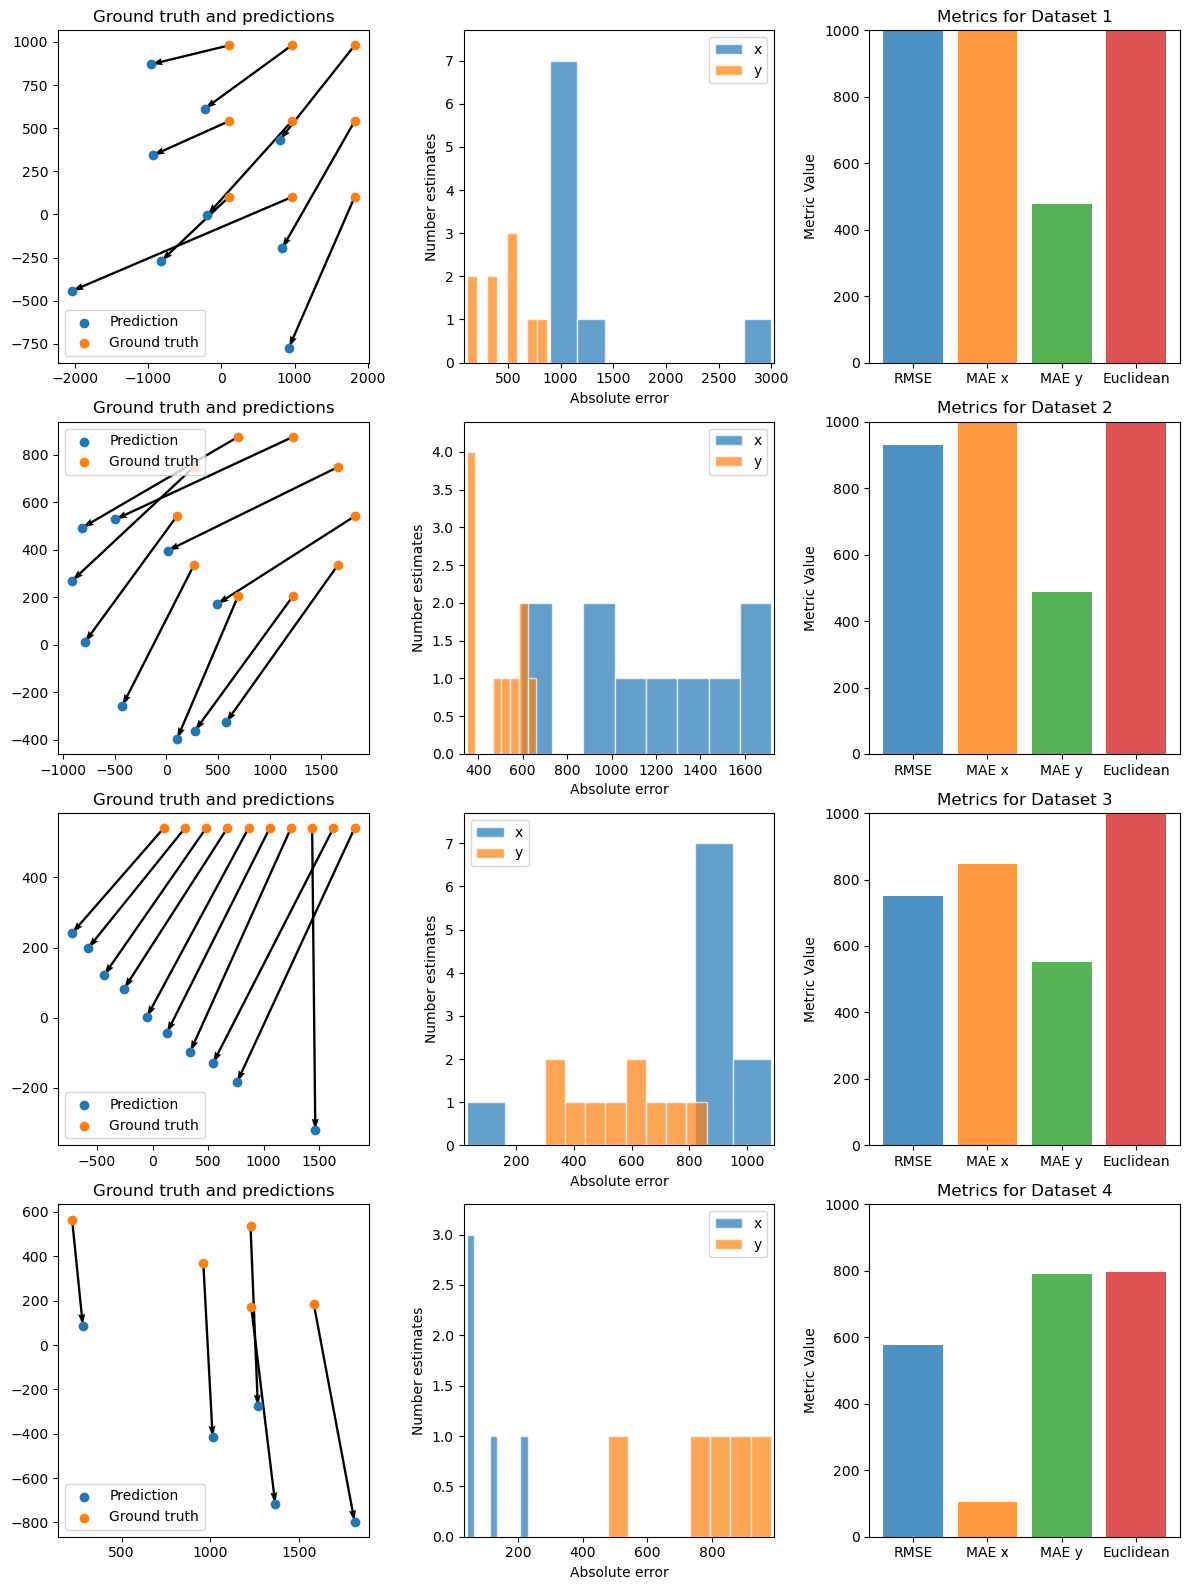

In [139]:
Thor_data = iml_util.gen_data_subject('test_subject_Thor')
results_linear_thor = results_for_model(LinearGaze(), D, Thor_data, 'pupils_n_train', 'screen_coordinates_train', 'pupils_test', 'screen_coordinates_test', 4)
iml_util.plot_results_grid(results_linear_thor, 4)



---
**Task 19 (medium): Evaluate♾️💡**
1. As in previous tasks, reflect on the results.


---

In [140]:
# Write your reflections here...

# Optional improvements
You may experience that the models behave differently on your dataset than on `test_subject_0`
 and `test_subject_3`
. This can be due to several factors, some of which you may have already reflected on in Task 8 in exercise Data preprocessing
. If you experience interesting behaviour in the predictions of your model you are of course welcome to explore it further such as:
- Different combinations of training set (use can use the creation of `D3_mod`
 for inspiration as to how to manipulate the combination of data for training and testing).     - If you have multiple data sets in your group, you can incoorporate those or use the ones provided, `test_subject_3`
 or `test_subject_1`
. 


- Other evaluation metrics
- Take inspiration from the optional exercises below, to explore your dataset further.


---
**Task 20 (medium): Explore your dataset👩‍💻♾️💡**
1. Investigate your results and explore options for improving predictions and evaluation.


---## Scale the data
In this task, you will improve the model using normalization. In Task 13, you reflected on the effect of having a large scale difference between input and output. Use the data of `test_subject_3`
 in dictionary `D3`
. 

---
**Task 21 (medium): Scale the data👩‍💻**
1. Complete the functions `normalize`
 and `denormalize`
. 
2. Train and test a model using normalized data from `test_subject_3`
. (Note that for the _grid_ pattern you are using the same data for testing and training).
3. Visualize the results using the function `plot_results_grid`
. 


---

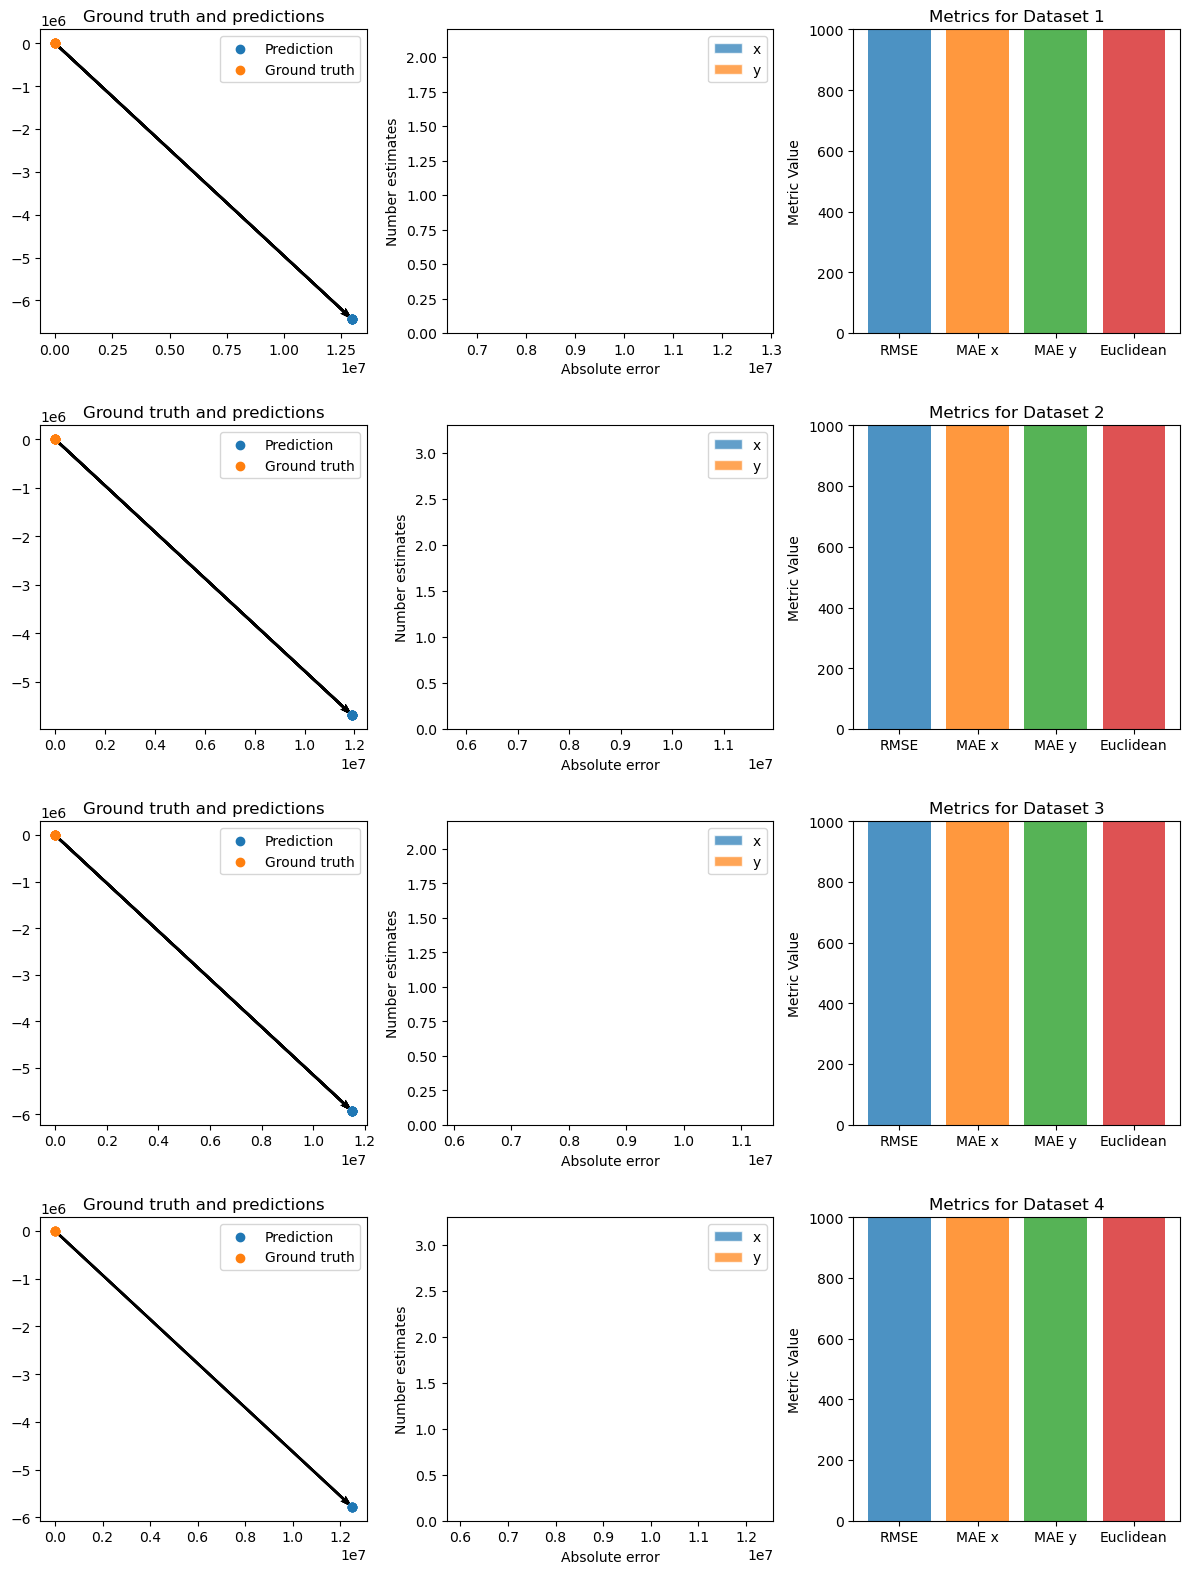

In [141]:
from sklearn.preprocessing import MinMaxScaler

def normalize(data_set):
    """
    Normalizes the pupil and screen coordinate data in the dataset using MinMaxScaler.
    
    Returns:
        d (list of dict): A list of dictionaries with normalized pupil and screen coordinate data.
        scaler (MinMaxScaler object): The fitted MinMaxScaler object used for normalization.
    """
    scaler = MinMaxScaler()
    
    # Normalize pupils and screen coordinates for training and testing
    for data in data_set:
        # Fit and transform training data (pupils and screen coordinates)
        data['pupils_train'] = scaler.fit_transform(data['pupils_train'])
        data['screen_coordinates_train'] = scaler.fit_transform(data['screen_coordinates_train'])
        
        # Transform test data based on the same scaler
        data['pupils_test'] = scaler.transform(data['pupils_test'])
        data['screen_coordinates_test'] = scaler.transform(data['screen_coordinates_test'])
    
    return data_set, scaler


def denormalize(dataset, scaler):
    """
    Denormalizes predicted and ground truth coordinates and calculates errors and performance metrics.
    
    Returns:
        d (dict): A dictionary where each key corresponds to a dataset index with denormalized predicted and ground truth coordinates.
    """
    results = {}
    
    for i, data in dataset.items():  # Correcting here to use .items() for dictionaries
        # Check if the data contains 'predicted' and 'ground_truth' keys
        if 'predicted' in data and 'ground_truth' in data:
            # Denormalize predicted and ground truth values
            predicted = scaler.inverse_transform(data['predicted'])
            ground_truth = scaler.inverse_transform(data['ground_truth'])
            
            # Calculate absolute errors
            errors = np.abs(predicted - ground_truth)
            
            # Calculate MSE, RMSE, MAE, and Euclidean distance
            mse = np.mean(errors ** 2, axis=0)
            rmse = np.sqrt(np.mean(mse))
            mae = np.mean(errors, axis=0)
            dist = np.mean(np.sqrt(np.sum(errors ** 2, axis=1)))
            
            # Store results in a dictionary
            results[i] = {
                'predicted': predicted,
                'ground_truth': ground_truth,
                'errors': errors,
                'mse': mse,
                'rmse': rmse,
                'dist': dist,
                'mae': mae
            }
        else:
            print(f"Warning: Missing 'predicted' or 'ground_truth' for dataset {i}")
    
    return results



# Write your code here for training, testing and visualizing results

D3 = iml_util.gen_data_subject('test_subject_3')

normalized_data, scaler = normalize(D3)

# Step 2: Train and test the model using the normalized data
results_normalized_thor = results_for_model(
    model=LinearGaze(),
    dataset_train=D,                       # Original training dataset
    dataset_test=normalized_data,          # Normalized test data (for all patterns)
    pupil_training_set='pupils_n_train',   # Training set key for pupils
    screen_training_set='screen_coordinates_train',  # Training set key for screen coordinates
    pupil_test_set='pupils_test',          # Test set key for pupils
    screen_test_set='screen_coordinates_test',  # Test set key for screen coordinates
    d_max=4                                # Maximum number of datasets (testing across all patterns)
)

# Step 3: Denormalize the results
denormalized_results = denormalize(results_normalized_thor, scaler)

# Step 4: Plot the denormalized results
iml_util.plot_results_grid(denormalized_results, 4)




---
**Task 22 (medium): Evaluation♾️💡**
1. Evaluate the results based on the plots and compare to the results from Task 11.
2. What possible pitfalls could there be in normalizing the data?
3. The pattern _line_ though improved, occurs to perform the worst, use your previous reflection from Task 8 in exercise Data preprocessing
 to reflect on why.


---

In [142]:
#Write your reflections here...

## Improve the model
This final part of the exercise requires you to modify  the gaze model $f_{\mathbf{w}}(x,y)$ into a quadratic model. As in [Task 5](#task_model), you will create a model for each output coordinate, i.e. $x', y'$. 
**Note:** In this step you create one model for each output coordinate seperately but it is possible to create a single model that simultaneously maps the $x'$- and $y'$-coordinates. However, we leave it as an optional exercise for you to figure out how to do this. Hint: You have to combine the design and parameter matrices.

Since the model is two-dimensional, the quadratic polynomial has  more model parameters than for one dimension model. The equation for each axis is:

$$
f(x, y) = a\cdot x^2 + b\cdot y^2 + c\cdot xy + d\cdot x + e\cdot y + f.
$$
The design matrices then have the following form:

---
**Task 23 (medium): Model improvements👩‍💻💡**
1. **Design matrix:** 
Argue why the desginmatrix for each output coordinate of the gaze mapping function is given by 

$$
D_x = D_y = \begin{bmatrix}
 		x_1^2 & y_1^2 & x_1y_1 & x_1 & y_1 & 1\\
  		x_2^2 & y_2^2 & x_2y_2 & x_2 & y_2 & 1\\
  		\vdots &&&&& \\
   		x_2^2 & y_2^2 & x_ny_n & x_n & y_n & 1\\
 	\end{bmatrix}.$$


2. **Implement model:** Implement the 2. order model and train it (calibrate) on each dataset.

3. **Evaluate:** Repeat the evaluation steps you did for the linear model above in [Task 2](#evaluation) (subtask 1-2). Additionally:
    - Create a barplot of the _rmse_ of both models for each dataset. Use the `bar_comparison_plot`
 function. 


4. **Compare with linear results:**
    - Is there a significant difference between the _rmse_'s of the linear and 2. order models? Explain why either is the case. Use your previous discussion of model limitations and error sources in your explanation.
    - Compare the scatter plots for the predictions vs. ground-truth for both models. Is there a qualitative difference in performance in some instances? Explain why either model performs better in particular cases and relate your answer to the previous question.




---

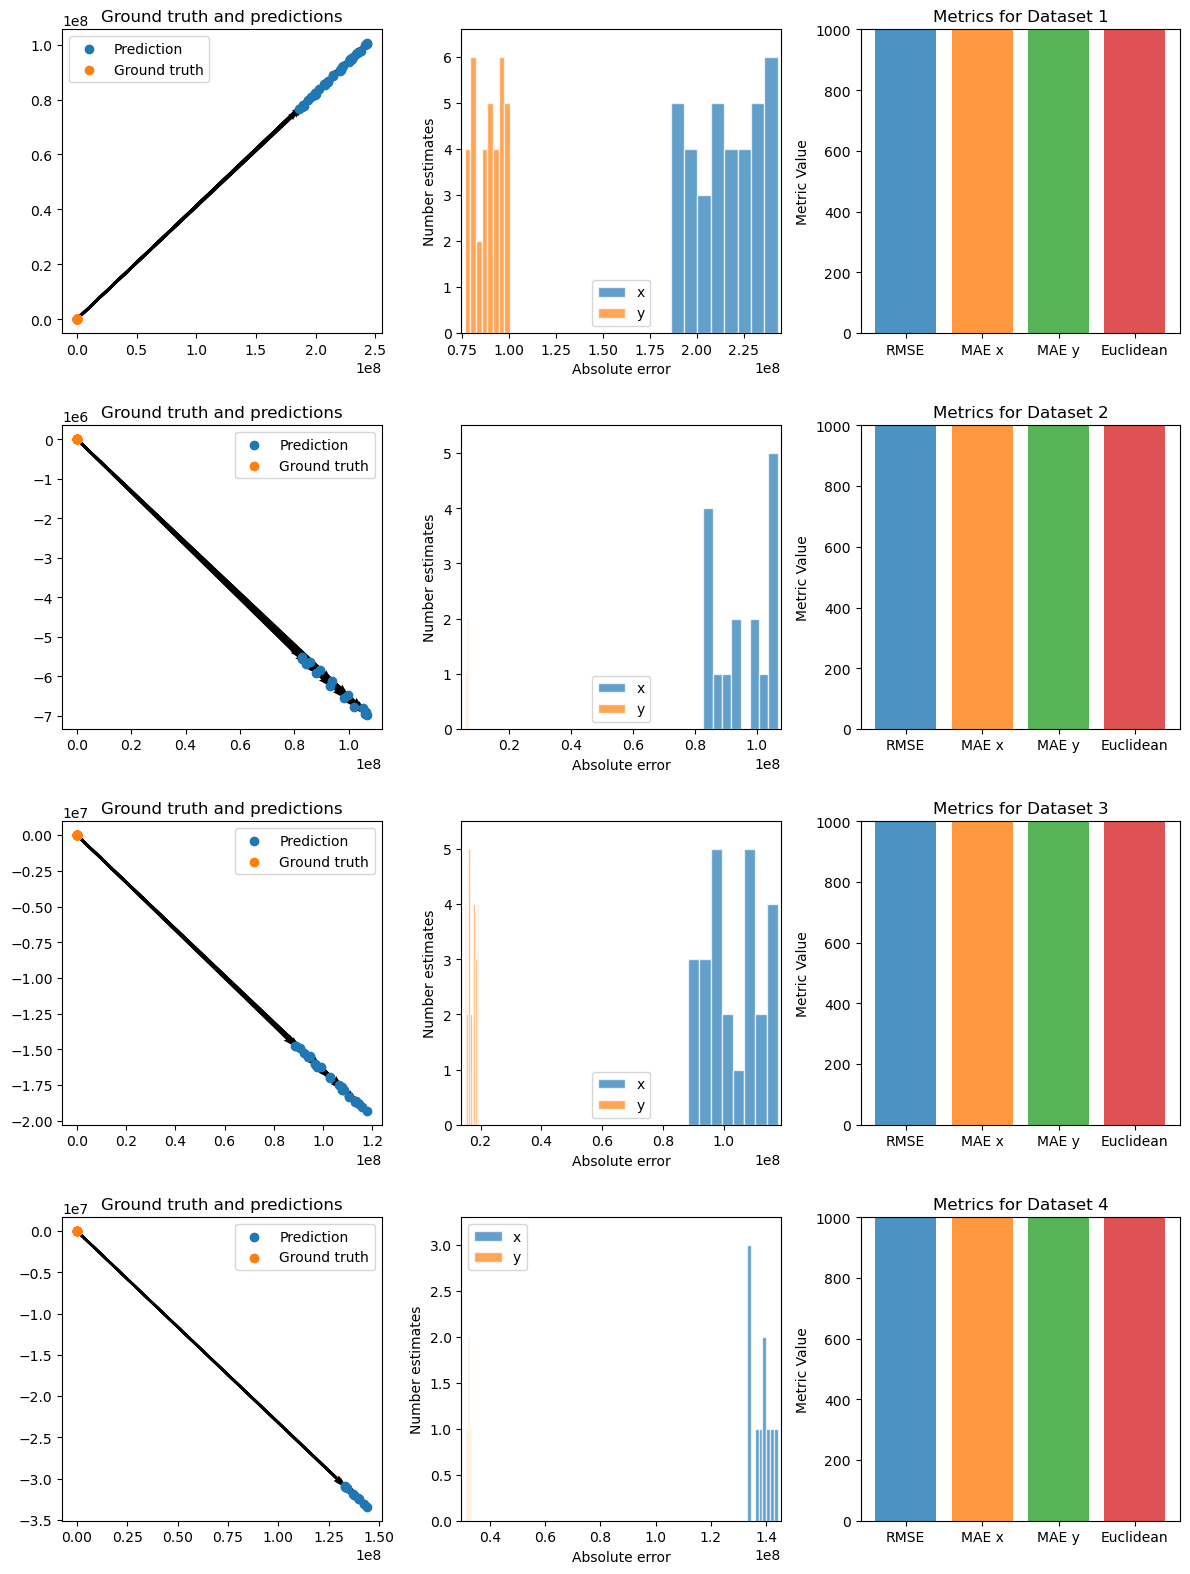

In [143]:
import numpy as np

# Step 1: Create the design matrix for quadratic terms
def get_design_matrix_quad(pupil_positions):
    """
    Constructs a quadratic design matrix.
    Parameters:
        pupil_positions (N x 2 numpy array): n samples, 2 features (px, py).

    Returns:
        design_matrix (N x 6 numpy array) : n_samples, 6 features for the quadratic model.
    """
    px = pupil_positions[:, 0]
    py = pupil_positions[:, 1]
    
    # Construct the quadratic design matrix
    design_matrix = np.column_stack([
        px ** 2,              # Quadratic term for x^2
        py ** 2,              # Quadratic term for y^2
        px * py,              # Interaction term x * y
        px,                   # Linear term for x
        py,                   # Linear term for y
        np.ones(px.shape),    # Constant term
    ])
    
    return design_matrix

# Step 2: Implement the quadratic prediction function
def quad(param, x):
    """
    Prediction function using the quadratic terms.

    Parameters:
        param (1D array): Array of parameters [a, b, c, d, e, f] for the quadratic equation.
        x (1D array): Array [px, py] representing the pupil position.

    Returns:
        Predicted value based on the quadratic equation.
    """
    return param[0] + param[1] * x[0] + param[2] * x[1] + param[3] * x[0] * x[1] + param[4] * x[0] ** 2 + param[5] * x[1] ** 2

# Step 3: Implement the QuadGaze class
class QuadGaze(GazeModel):
    def calibrate(self, dataset, pupil_training_set, screen_training_set):
        """
        Calibrates the QuadGaze model by fitting two quadratic regression models for x and y coordinates
        based on the training dataset.

        Parameters:
            dataset (dict): The dictionary D containing the training data with two keys:
                - "pupils_train" (N x 2 numpy array): n samples, 2 features (px, py) representing pupil positions.
                - "positions_train" (N x 2 numpy array): n samples, 2 features (screen coordinates x, y) representing
                  the true gaze positions on the screen.
        """
        pupils_train = dataset[pupil_training_set]
        positions_train = dataset[screen_training_set]

        # Create design matrix from pupil training data
        design_matrix = get_design_matrix_quad(pupils_train)
        
        # Solve for the parameters using least squares for both x and y coordinates
        self.model_x = np.linalg.lstsq(design_matrix, positions_train[:, 0], rcond=None)[0]  # Fit for x
        self.model_y = np.linalg.lstsq(design_matrix, positions_train[:, 1], rcond=None)[0]  # Fit for y

    def predict(self, pupil):
        """
        Predicts the gaze position (x, y) based on the given pupil position using the calibrated model.

        Parameters:
            pupil (1 x 2 numpy array): 2 features (px, py) representing the current pupil position.

        Returns:
            x, y (float, float): Predicted gaze position (x, y) based on the quadratic model.
        """
        # Predict both x and y coordinates using the calibrated models
        predicted_x = quad(self.model_x, pupil)
        predicted_y = quad(self.model_y, pupil)
        
        return predicted_x, predicted_y

# Step 4: Evaluate the quadratic model
results_quad = results_for_model(
    model=QuadGaze(),
    dataset_train=D, 
    dataset_test=D, 
    pupil_training_set='pupils_n_train', 
    screen_training_set='screen_coordinates_train', 
    pupil_test_set='pupils_n_test', 
    screen_test_set='screen_coordinates_test', 
    d_max=4
)

# Step 5: Visualize the results
iml_util.plot_results_grid(results_quad, 4)



---
**Task 24 (medium): Evaluation♾️💡**
1. Reflect on how the higher order model performs compared to the linear model.    - Does it reduce the error more effectively than the linear model?
    - Does it seem to overfit the training data? Why? Why not?
    - When plotting the residuals, do you notice any patterns for the higher-order model that are not present in the linear model?




---
**Submission**
For submission details click [here](https://iml.itu.dk/01-about_the_course/01-AboutTheCourse.html)

Use the [learnIt](https://learnit.itu.dk/)
 page for submission of the handin.

